# MBA em Data Science and Analytics
## Trabalho de conclusão de curso (TCC)
Autor: **Renato Fernandes de Souza** <br>
Orientador: **Nuno Manoel Martins Dias Fouto** <br>
Ano: **2022**
### Utilização do Preço da Liquidação das Diferenças horário na predição de geração eólica
1. Construção da curva de potência com base nos dados de geração reais passados
2. Predição da velocidade do vento através da análise de séries temporais
3. Predição da geração de energia, relacionando a velocidade do vento predita e a curva de potência
4. Predição da exposição horária, relacionando a energia predita e o PLD horário do dia seguinte

# Importação de pacotes

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import boto3
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

import statsmodels.api as sm
import statsmodels.formula.api as smf

from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr

from scipy import stats

mpl.rcParams["text.usetex"] = False

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Unable to determine R home: [WinError 2] O sistema não pode encontrar o arquivo especificado


In [ ]:
# referencias
# https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting/notebook

# Carregamento da base de dados

In [2]:
#df_original = pd.read_csv("D:\\OneDrive\\Faculdade\\MBA\TCC\\Datasets\\archive\\T1.csv", sep=',')
df_original = pd.read_csv("D:\\OneDrive\\Faculdade\\MBA\\TCC\\Datasets\\archive (1)\\Turbine_Data.csv")

In [3]:
df_pld = pd.read_parquet("C:\\Users\\renat\\Downloads\\2018-11.parquet")
df_pld.Data.min()

Timestamp('2018-11-01 00:00:00')

# previsualizando dataset

In [3]:
df_original.head()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [5]:
df_dtypes = pd.DataFrame(df_original.dtypes).reset_index().rename(columns={'index': 'Coluna', 0: 'Tipo de dados'})
df_dtypes['Descrição'] = ['Data e hora da observação', 'Potência ativa de saída do aerogerador', 
                          'Velocidade do vento medida no aerogerador', 'Potência ativa de saída teórica',
                          'Direção do vento']
df_styler = df_dtypes.style.set_properties(**{'text-align': 'left'})
df_styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
#df_dtypes

,Coluna,Tipo de dados,Descrição
0,Date/Time,object,Data e hora da observação
1,LV ActivePower (kW),float64,Potência ativa de saída do aerogerador
2,Wind Speed (m/s),float64,Velocidade do vento medida no aerogerador
3,Theoretical_Power_Curve (KWh),float64,Potência ativa de saída teórica
4,Wind Direction (°),float64,Direção do vento


In [4]:
df_original.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94750.000000,93817.000000,62518.000000,41996.000000,41891.000000,41891.000000,62160.0,62540.000000,62438.000000,62295.000000,62427.000000,62449.000000,62406.000000,62507.000000,72278.000000,94748.000000,62127.000000,6.290800e+04,72278.000000,94595.000000
mean,619.109805,28.774654,43.010189,9.749641,10.036535,10.036535,0.0,64.234170,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,196.290539,88.133966,9.907500,2.280429e+03,196.290539,5.878960
std,611.275373,4.369145,5.545312,20.644828,20.270465,20.270465,0.0,10.455556,6.323895,528.063946,22.627489,22.650255,5.178711,5.732783,88.296554,116.596725,4.718421,3.586034e+05,88.296554,2.619084
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,79.642258,25.627428,39.840247,-0.939849,-0.433264,-0.433264,0.0,57.872242,53.942181,1029.812177,55.492241,54.763998,33.943949,35.812500,145.000000,-0.432137,9.231091,2.000000e+00,145.000000,3.823330
50%,402.654893,28.340541,42.910877,0.394399,0.888977,0.888977,0.0,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,182.000000,35.883659,10.098702,2.000000e+00,182.000000,5.557765
75%,1074.591780,31.664772,47.007976,8.099302,8.480194,8.480194,0.0,71.079306,61.305312,1515.402005,85.867449,85.337740,40.008425,43.359375,271.000000,147.359075,13.600413,2.000000e+00,271.000000,7.506710
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,0.0,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


In [6]:
# null values wind speed
df_original['WindSpeed'].isna().sum()

23629

In [7]:
# null values wind speed
df_original['ActivePower'].isna().sum()

23474

# Formatando dataset

In [21]:
df = df_original.copy()
#df = df.rename(columns={'Unnamed: 0':'Date/Time'})
df['datetime'] = pd.to_datetime(df['Unnamed: 0']).dt.tz_localize(None)
df['power'] = df['ActivePower']
df['windspeed'] = df['WindSpeed']
df.drop(columns=df_original.columns,
        inplace=True)
df.dtypes

datetime     datetime64[ns]
power               float64
windspeed           float64
dtype: object

In [22]:
df = df.round(2)

In [23]:
start_dt = dt.datetime(2018,10,1)
df = df[df['datetime'] >= start_dt]
df[df['datetime'] >= start_dt].head()
df = df.dropna()

In [24]:
df.set_index('datetime', inplace=True)
df.head()

,power,windspeed
datetime,,
2018-10-01 00:00:00,449.05,5.97
2018-10-01 00:10:00,542.97,6.22
2018-10-01 00:20:00,396.30,5.68
2018-10-01 00:30:00,320.35,5.39
2018-10-01 00:40:00,260.21,5.12


# Análise descritiva

[Text(0.5, 1.0, 'Distribuição da velocidade do vento')]

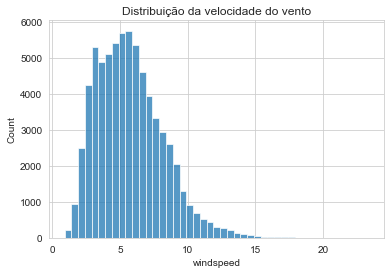

In [25]:
sns.set_style("whitegrid")
sns.histplot(df['windspeed'], binwidth=0.5).set(title='Distribuição da velocidade do vento')

In [27]:
# weibull distribution
arrWind = df['windspeed'].values
try:
    k_weibull = np.power(arrWind.std() / arrWind.mean(), -1.086)
except ZeroDivisionError:
    k_weibull = 2  # distribuição de rayleigh (default)
try:
    c_weibull = arrWind.mean() / math.gamma(1 + (1 / k_weibull))
except ZeroDivisionError:
    c_weibull = 1
dx = 0.5
bins = np.arange(0, 25, dx)

def f_weibull(v, k, c):
    return (k / c) * np.power((v / c), k - 1) * np.exp(-np.power(v / c, k))

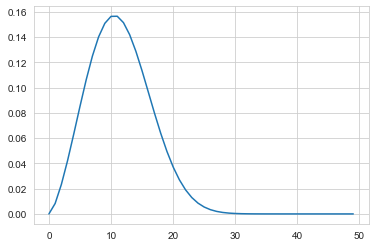

weibull parameters: k=2.51, c=6.44


In [28]:
plt.plot(f_weibull(bins, k_weibull, c_weibull))
plt.show()
print(f'weibull parameters: k={round(k_weibull, 2)}, c={round(c_weibull, 2)}')

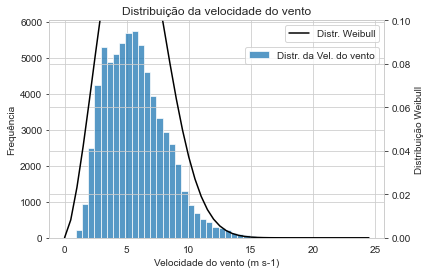

In [29]:
df_weibull = pd.DataFrame({'weibull':f_weibull(bins, k_weibull, c_weibull), 'bins': bins})

fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
plt.ylim(0, 0.1)

sns.histplot(df['windspeed'], binwidth=0.5, ax=ax1, label='Distr. da Vel. do vento').set(title='Distribuição da velocidade do vento')
sns.lineplot(data=df_weibull, x='bins', y='weibull', ax=ax2, color='black', label='Distr. Weibull')

ax1.set_xlabel('Velocidade do vento (m s-1)')
ax1.set_ylabel('Frequência')
ax2.set_ylabel('Distribuição Weibull')
ax1.set_title('Distribuição da velocidade do vento')
ax1.legend(loc=(0.585, 0.8))
#df_weibull

In [30]:
# teste de aderência à distribuição weibull
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html#scipy.stats.weibull_min

# stats.kstest(df['windspeed'], stats.weibull_min.pdf(df['windspeed'], 1.88))

# KS test for goodness of fit: p-value > 0.05 =
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
params = stats.weibull_min.fit(df['windspeed']/np.max(np.histogram(df['windspeed'])[0]))

print(f'params {params}')
print(stats.kstest(df['windspeed'], stats.weibull_min.name, params))

#rv = stats.weibull_min(c=1.88, loc=0, scale=8.51)
#data = rv.rvs(1000)
#plt.hist(data)
print(np.histogram(df['windspeed'])[0])

params (0.14827251595616536, 3.8759689922480616e-05, 1.5964446269173338)
KstestResult(statistic=0.6264380078734566, pvalue=0.0)
[10157 23220 21536 10852  2944   921   253    59    12     1]


In [31]:
# KS test for goodness of fit
distributions = [
    stats.norm, stats.beta, stats.expon, stats.gamma, stats.genextreme, stats.logistic, stats.lognorm, stats.triang, stats.uniform, stats.fatiguelife, 
    stats.gengamma, stats.gennorm, stats.dweibull, stats.dgamma, stats.gumbel_r, stats.powernorm, stats.rayleigh, stats.weibull_max, stats.weibull_min,
    stats.laplace, stats.alpha, stats.genexpon, stats.bradford, stats.betaprime, stats.burr, stats.fisk, stats.genpareto, stats.hypsecant,
    stats.halfnorm, stats.halflogistic, stats.invgauss, stats.invgamma, stats.levy, stats.loglaplace, stats.loggamma, stats.maxwell,
    stats.mielke, stats.ncx2, stats.ncf, stats.nct, stats.nakagami, stats.pareto, stats.lomax, stats.powerlognorm, stats.powerlaw, stats.rice,
    stats.semicircular, stats.trapezoid, stats.rice, stats.invweibull, stats.foldnorm, stats.foldcauchy, stats.cosine, stats.exponpow,
    stats.exponweib, stats.wald, stats.wrapcauchy, stats.truncexpon, stats.truncnorm, stats.t, stats.rdist
    ]


def kstest(data, distname, paramtup):
    ks = stats.kstest(data, distname, paramtup)[1]   # return p-value
    return ks             # return p-value

# distribution fitter and call to KS test

def fitdist(data, dist):    
    fitted = dist.fit(data)
    ks = kstest(data, dist.name, fitted)
    res = (dist.name, ks, *fitted)
    return res

# call fitting function for all distributions in list
res = [fitdist(df['windspeed'],D) for D in distributions]

# convert the fitted list of tuples to dataframe
pd.options.display.float_format = '{:,.3f}'.format
dft = pd.DataFrame(res, columns=["distribution", "KS p-value", "param1", "param2", "param3", "param4", "param5"])
dft["distobj"] = distributions
dft.sort_values(by=["KS p-value"], inplace=True, ascending=False)
dft.reset_index(inplace=True)
dft.drop("index", axis=1, inplace=True)
dft

D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_continuous_distns.py:647: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_continuous_distns.py:809: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_continuous_distns.py:813: RuntimeWarning: 

,distribution,KS p-value,param1,param2,param3,param4,param5,distobj
0,weibull_min,0.000,2.074,0.899,5.448,NaN,NaN,<scipy.stats._continuous_distns.weibull_min_ge...
1,gengamma,0.000,1.810,1.481,0.887,3.428,NaN,<scipy.stats._continuous_distns.gengamma_gen o...
2,nakagami,0.000,1.093,0.899,5.407,NaN,NaN,<scipy.stats._continuous_distns.nakagami_gen o...
3,powerlognorm,0.000,133.388,1.327,0.784,137.212,NaN,<scipy.stats._continuous_distns.powerlognorm_g...
4,betaprime,0.000,4.635,"11,725.172",0.391,"13,458.705",NaN,<scipy.stats._continuous_distns.betaprime_gen ...
...,...,...,...,...,...,...,...,...
56,ncx2,0.000,2.811,0.000,0.900,1.617,NaN,<scipy.stats._continuous_distns.ncx2_gen objec...
57,rayleigh,0.000,8.693,2.727,NaN,NaN,NaN,<scipy.stats._continuous_distns.rayleigh_gen o...
58,levy,0.000,0.888,3.412,NaN,NaN,NaN,<scipy.stats._continuous_distns.levy_gen objec...
59,genexpon,0.000,0.000,0.626,1.975,0.900,2.446,<scipy.stats._continuous_distns.genexpon_gen o...


Text(0, 0.5, 'Frequência')

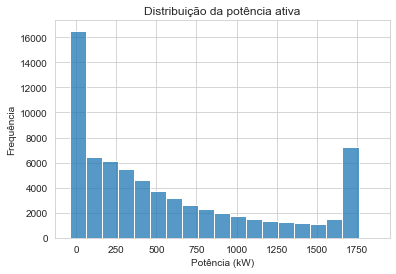

In [32]:
sns.histplot(df['power'], binwidth=100).set(title='Distribuição da potência ativa')
plt.xlabel('Potência (kW)')
plt.ylabel('Frequência')

In [33]:
correlation_matrix = df.corr()
correlation_matrix

,power,windspeed
power,1.000,0.938
windspeed,0.938,1.000


<AxesSubplot:>

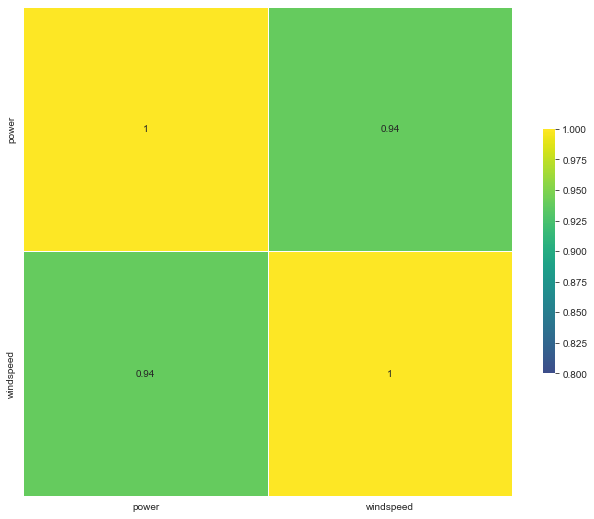

In [34]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, vmin=0.8, vmax=1.0, center=0.87, cmap="viridis", annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:xlabel='windspeed', ylabel='power'>

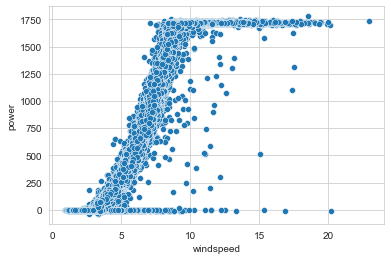

In [35]:
# potência em função da velocidade do vento
sns.scatterplot(data=df, x='windspeed', y='power')

<AxesSubplot:xlabel='datetime', ylabel='windspeed'>

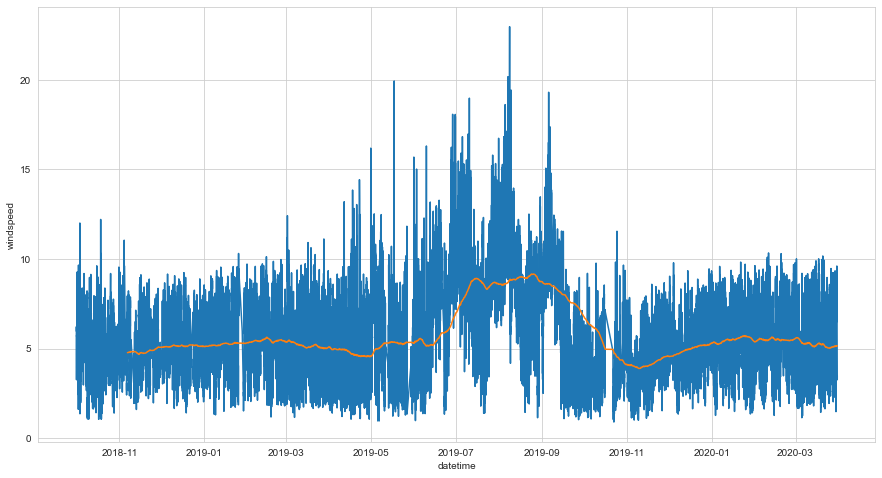

In [36]:
# visualização dos dados ao longo do tempo
plt.figure(figsize=(15,8))
sns.lineplot(data=df['windspeed'])
sns.lineplot(data=df['windspeed'].rolling(6 * 24 * 30).mean())

<AxesSubplot:xlabel='datetime', ylabel='power'>

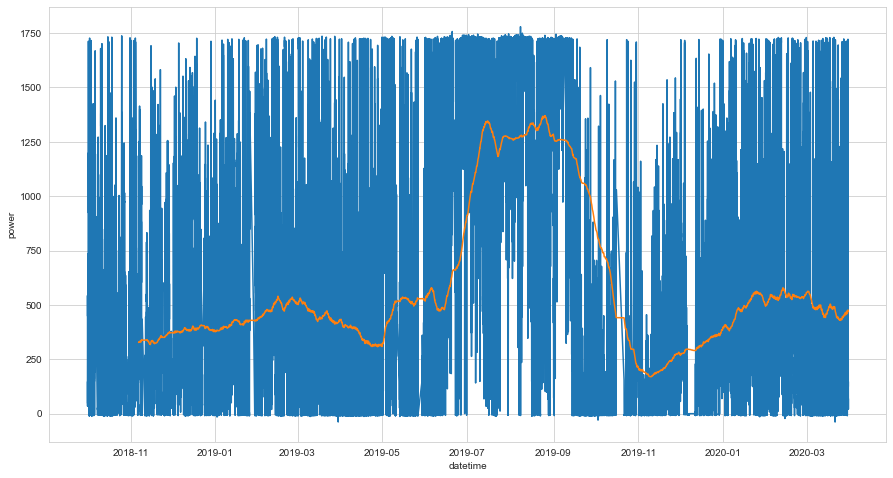

In [37]:
# visualização dos dados ao longo do tempo
plt.figure(figsize=(15,8))
sns.lineplot(data=df['power'])
sns.lineplot(data=df['power'].rolling(6 * 24 * 30).mean())

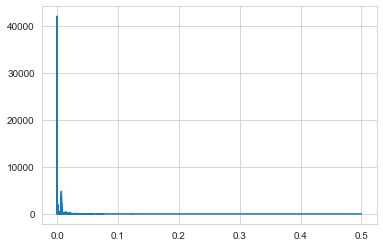

In [38]:
# seasonality with sarima model
from scipy import signal
f, Pxx = signal.periodogram(df['windspeed'])
plt.plot(f, Pxx)

In [39]:
top_3_periods = {}

# get indices for 3 highest Pxx values
top3_freq_indices = np.flip(np.argsort(Pxx), 0)[0:4]

# use indices from previous step to
# get 3 frequencies with highest power
freqs = f[top3_freq_indices]

# use same indices to get powers as well
power = Pxx[top3_freq_indices]

# we are interested in period and it is calculated as 1/frequency 
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_3_periods['period1'] = periods[0]
top_3_periods['freq1'] = freqs[0]
top_3_periods['power1'] = power[0]

top_3_periods['period2'] = periods[1]
top_3_periods['freq2'] = freqs[1]
top_3_periods['power2'] = power[1]

top_3_periods['period3'] = periods[2]
top_3_periods['freq3'] = freqs[2]
top_3_periods['power3'] = power[2]

top_3_periods['period4'] = periods[3]
top_3_periods['freq4'] = freqs[3]
top_3_periods['power4'] = power[3]
top_3_periods

# sazonalidades:
# anual
# a cada 2 meses
# mensal
# a cada 4..5 dias (semanal)

{'period1': 23318.333333333336,
 'freq1': 4.2884711600314486e-05,
 'power1': 42070.77914296568,
 'period2': 69955.0,
 'freq2': 1.4294903866771496e-05,
 'power2': 38242.6503560144,
 'period3': 34977.5,
 'freq3': 2.858980773354299e-05,
 'power3': 35503.136181284215,
 'period4': 17488.75,
 'freq4': 5.717961546708598e-05,
 'power4': 8849.687559015423}

In [40]:
df_media_horaria = df.copy()
df_media_horaria['datetime_hourly'] = df_media_horaria.index.strftime('%Y-%m-%d %H')
df_media_horaria = df_media_horaria.groupby('datetime_hourly').mean().reset_index()
df_media_horaria['datetime_hourly'] = pd.to_datetime(df_media_horaria['datetime_hourly'])
df_media_horaria.set_index('datetime_hourly', inplace=True)

df_media_horaria.head(10)

,power,windspeed
datetime_hourly,,
2018-10-01 00:00:00,359.452,5.508
2018-10-01 01:00:00,85.282,3.720
2018-10-01 02:00:00,86.682,3.763
2018-10-01 03:00:00,197.393,4.395
2018-10-01 04:00:00,359.057,5.242
2018-10-01 05:00:00,373.017,5.237
2018-10-01 06:00:00,319.968,5.298
2018-10-01 07:00:00,377.332,5.195
2018-10-01 08:00:00,521.788,5.745


# Tratamento dos dados
Conforme conhecimento prévio (empírico), os dados precisam ser filtrados de acordo com alguns critérios:

| Descrição do outlier  | Condição  |
|---|---|
| Erros de medição  | Fazer p=0 para todo v < v_cut_in  |
| Aerogerador parado  | Fazer p=NaN se p<=0.001*p_nominal para todo v_cut_in <= v <= v_cut_off  |
|  Aerogerador em estado de transição | Fazer p=NaN enquanto houver dados desbalanceados entre o quantil 5, 50 e 50, 95 para todo v_cut_in <= v <= v_cut_off |
1. Calcular a média horária dos dados para possibilitar a conciliação com os valores do PLD (horário)
2. Zerar potências > 0.1 % da nominal (IEC61400-12)(3600kW) cuja velocidade do vento seja < 3.5 m/s (indicando erros de medição, uma vez que o aerogerador não produz
                                                                a velocidades baixas)
3. Remover potências cujo valor é <= 0.1 % da nominal (3600kW) e a vel. do vento seja >= 3.5 (indicando que havia disponibilidade de recursos naturais
                                                                              porém o aerogerador não produziu devido a alguma condição
                                                                              de falha ou parada programada)


Text(0.5, 1.0, 'Curva de potência com dados de medições brutas do aerogerador')

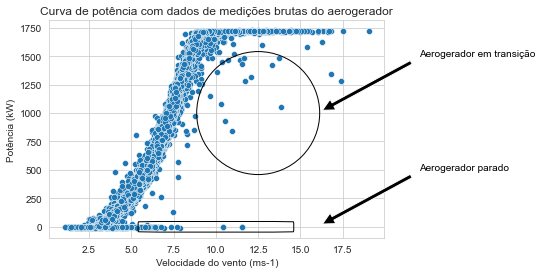

In [46]:
# potência em função da velocidade do vento após média horária
ax = sns.scatterplot(data=df_media_horaria, x='windspeed', y='power')
# add text annotation
#plt.annotate("Restrição de operação", xy=(21, 3400), xycoords='data',
#            xytext=(22, 2800), textcoords='data',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='left', size='medium', color='black', weight='normal')
#t = plt.text(
#    18, 3450, "                                            ", 
#    ha="center", va="center", rotation=0, size=10,
#    bbox=dict(boxstyle="round4,pad=0.1", fill=False, ec="black", lw=1))

plt.annotate("Aerogerador parado", xy=(16, 0), xycoords='data',
            xytext=(22, 500), textcoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='left', size='medium', color='black', weight='normal')
#t = plt.text(
#    18, 3450, "                                            ", 
#    ha="center", va="center", rotation=0, size=10,
#    bbox=dict(boxstyle="round4,pad=0.1", fill=False, ec="black", lw=1))

t = plt.text(
    10, 0, "                                                        ", 
    ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="round4,pad=0.1", fill=False, ec="black", lw=1))

plt.annotate("Aerogerador em transição", xy=(16, 1000), xycoords='data',
            xytext=(22, 1500), textcoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='left', size='medium', color='black', weight='normal')

t = plt.text(
    12.5, 1000, "                                            ", 
    ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="circle,pad=0.1", fill=False, ec="black", lw=1))
ax.set_xlabel('Velocidade do vento (ms-1)')
ax.set_ylabel('Potência (kW)')
ax.set_title('Curva de potência com dados de medições brutas do aerogerador')

In [56]:
power_cut_in = 0.001 * 3600
wind_cut_in = 3.0
df_media_horaria.query('windspeed < @wind_cut_in')

,power,windspeed
datetime_hourly,,
2018-10-02 10:00:00,-5.518,2.357
2018-10-03 03:00:00,-5.945,2.463
2018-10-03 04:00:00,-1.535,2.970
2018-10-03 14:00:00,-6.617,1.863
2018-10-03 15:00:00,-5.998,2.207
...,...,...
2020-03-28 02:00:00,-5.683,2.457
2020-03-29 03:00:00,-5.655,2.623
2020-03-30 01:00:00,-5.717,2.018


In [57]:
# remover erros de medição de potência
df_media_horaria_erro_med = df_media_horaria.copy()
df_media_horaria_erro_med.loc[(df_media_horaria_erro_med['windspeed'] < wind_cut_in),'power'] = 0.0
df_media_horaria_erro_med.query('windspeed < @wind_cut_in')

,power,windspeed
datetime_hourly,,
2018-10-02 10:00:00,0.000,2.357
2018-10-03 03:00:00,0.000,2.463
2018-10-03 04:00:00,0.000,2.970
2018-10-03 14:00:00,0.000,1.863
2018-10-03 15:00:00,0.000,2.207
...,...,...
2020-03-28 02:00:00,0.000,2.457
2020-03-29 03:00:00,0.000,2.623
2020-03-30 01:00:00,0.000,2.018


In [58]:
df_media_horaria_erro_med.head(10)

,power,windspeed
datetime_hourly,,
2018-10-01 00:00:00,359.452,5.508
2018-10-01 01:00:00,85.282,3.720
2018-10-01 02:00:00,86.682,3.763
2018-10-01 03:00:00,197.393,4.395
2018-10-01 04:00:00,359.057,5.242
2018-10-01 05:00:00,373.017,5.237
2018-10-01 06:00:00,319.968,5.298
2018-10-01 07:00:00,377.332,5.195
2018-10-01 08:00:00,521.788,5.745


In [59]:
# remover medições cujo aerogerador está parado ou com falha
df_media_horaria_erro_med.query('power <= @power_cut_in and windspeed >= @wind_cut_in')

,power,windspeed
datetime_hourly,,
2018-10-03 02:00:00,1.173,3.088
2018-10-04 00:00:00,-8.037,3.053
2018-10-04 04:00:00,-5.397,3.595
2018-10-04 05:00:00,-6.878,3.913
2018-10-04 06:00:00,-5.565,4.003
...,...,...
2020-03-23 06:00:00,-0.133,3.080
2020-03-28 04:00:00,-3.678,3.463
2020-03-28 05:00:00,-5.222,4.667


In [60]:
df_media_horaria_erro_med.loc[(df_media_horaria_erro_med['power'] <= power_cut_in) & (df_media_horaria_erro_med['windspeed'] >= wind_cut_in),'power'] = np.nan
df_media_horaria_erro_med.query('power <= @power_cut_in and windspeed >= @wind_cut_in')

,power,windspeed
datetime_hourly,,


In [61]:
# remover medições onde o aerogerador excede o limite de Betz (16/27~0.59)
# 1. Calcular o coeficiente de potencia teórico
# 2. Remover pontos onde o limite seja maior do que 0.59
# A=10715m² e p(rho)=1.225
df_media_horaria_erro_med['cp'] = 2*df_media_horaria_erro_med['power'] / (1.225*df_media_horaria_erro_med['windspeed']*10715)
df_media_horaria_erro_med.cp.max()

0.03162621861481177

In [48]:
# remover medições onde o aerogerador encontra-se em transição de estado
# 1. criar bins de 0.5 m/s
# 2. efetuar boxplot para identificar outliers
dx = 0.5
bins = np.arange(0, 25, dx)
df_binned = df_media_horaria.copy()
df_binned['bin'] = pd.cut(df_binned["windspeed"], bins)
df_binned

,power,windspeed,bin
datetime_hourly,,,
2018-10-01 00:00:00,359.452,5.508,"(5.5, 6.0]"
2018-10-01 01:00:00,85.282,3.720,"(3.5, 4.0]"
2018-10-01 02:00:00,86.682,3.763,"(3.5, 4.0]"
2018-10-01 03:00:00,197.393,4.395,"(4.0, 4.5]"
2018-10-01 04:00:00,359.057,5.242,"(5.0, 5.5]"
...,...,...,...
2020-03-30 19:00:00,763.008,6.798,"(6.5, 7.0]"
2020-03-30 20:00:00,501.957,5.943,"(5.5, 6.0]"
2020-03-30 21:00:00,176.390,4.543,"(4.5, 5.0]"


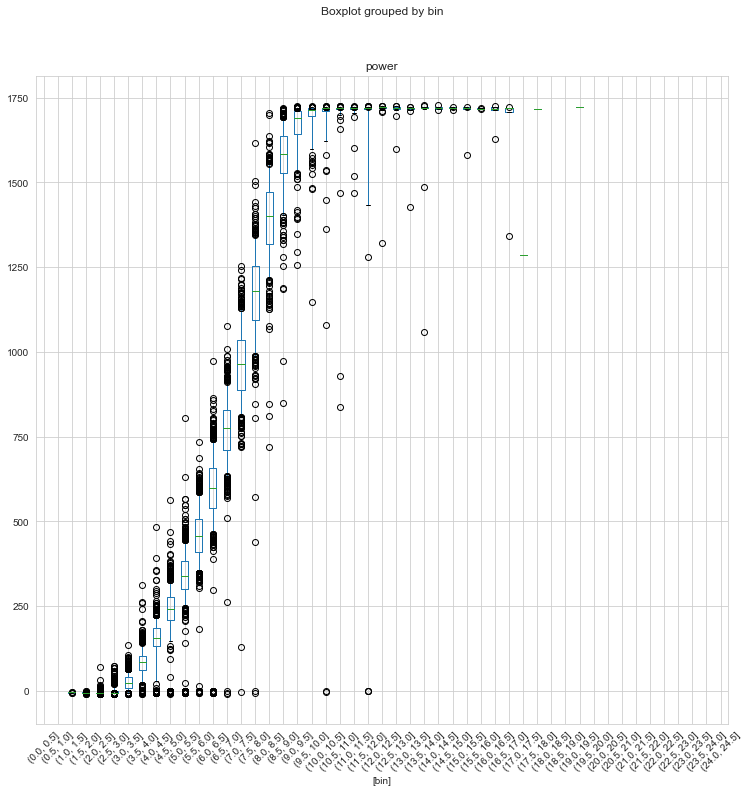

In [49]:
bp = df_binned.boxplot(column=['power'], by=['bin'], rot=45, figsize=(12,12), return_type='dict', whis=[5,95])

In [50]:
# print(bp['power'])
outliers = [flier.get_ydata() for flier in bp['power']["fliers"]]
boxes = [box.get_ydata() for box in bp['power']["boxes"]]
medians = [median.get_ydata() for median in bp['power']["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp['power']["whiskers"]]
print(outliers[26])
print(medians[26])
print(whiskers[26])
print(boxes[26])

[1426.58 1711.5083333333332 1724.0366666666666 1722.5466666666669]
[1719.65666667 1719.65666667]
[710.68541667 633.91833333]
[1717.04416667 1717.04416667 1720.65583333 1720.65583333 1717.04416667]


In [51]:
df_binned.groupby('bin').quantile([0.01,0.25,0.5,0.75,0.99]).to_clipboard()
df_described = df_binned[['power', 'bin']].groupby('bin').describe()

df_described['iqr'] = df_described['power']['75%'] - df_described['power']['25%']
df_described['inner_fence'] = 1.5 * df_described['iqr']
df_described['outer_fence'] = 3 * df_described['iqr']
df_described['lower_inner'] = df_described['power']['25%'] - df_described['inner_fence']
df_described['lower_outer'] = df_described['power']['25%'] - df_described['outer_fence']
df_described

power                                                  \
                 count      mean     std       min       25%       50%   
bin                                                                      
(0.0, 0.5]       0.000       NaN     NaN       NaN       NaN       NaN   
(0.5, 1.0]       0.000       NaN     NaN       NaN       NaN       NaN   
(1.0, 1.5]      25.000    -4.929   0.895    -7.547    -5.053    -4.835   
(1.5, 2.0]     160.000    -5.199   0.905    -9.060    -5.546    -5.124   
(2.0, 2.5]     462.000    -5.012   4.569    -9.695    -5.960    -5.518   
(2.5, 3.0]     786.000    -0.573  10.849    -8.802    -5.841    -5.287   
(3.0, 3.5]     883.000    25.861  22.229    -9.870     8.297    23.673   
(3.5, 4.0]     897.000    82.997  37.364    -9.297    60.535    83.995   
(4.0, 4.5]     931.000   153.932  53.933    -7.610   131.839   154.770   
(4.5, 5.0]     946.000   236.515  70.645    -8.805   208.471   242.829   
(5.0, 5.5]   1,032.000   337.504  80.725    -7.520   299.619   339.981   
(5.5, 6.0]     953.000   456.293  86.420    -5.247   409.073   455.710   
(6.0, 6.5]     896.000   593.239 116.832    -6.825   540.486   599.437   
(6.5, 7.0]     766.000   768.560  98.571    -8.058   710.685   775.244   
(7.0, 7.5]     675.000   961.116 109.843    -4.572   886.588   963.985   
(7.5, 8.0]     556.000 1,168.200 137.041    -7.220 1,094.475 1,178.274   
(8.0, 8.5]     491.000 1,391.246 116.655   719.252 1,317.108 1,400.475   
(8.5, 9.0]     411.000 1,570.595  99.797   848.554 1,529.262 1,584.562   
(9.0, 9.5]     282.000 1,665.085  71.965 1,255.532 1,644.025 1,691.294   
(9.5, 10.0]    215.000 1,693.598  56.626 1,148.310 1,696.062 1,713.228   
(10.0, 10.5]   156.000 1,678.913 203.563    -4.007 1,710.404 1,718.190   
(10.5, 11.0]   106.000 1,699.109 116.723   838.197 1,717.616 1,719.081   
(11.0, 11.5]    73.000 1,710.983  39.564 1,469.583 1,718.098 1,719.425   
(11.5, 12.0]    64.000 1,623.159 369.592     0.000 1,717.215 1,719.185   
(12.0, 12.5]    55.000 1,713.228  53.965 1,321.097 1,718.998 1,721.213   
(12.5, 13.0]    41.000 1,716.528  19.608 1,597.850 1,717.530 1,720.245   
(13.0, 13.5]    23.000 1,706.346  61.061 1,426.580 1,717.044 1,719.657   
(13.5, 14.0]    25.000 1,684.586 138.853 1,057.385 1,718.190 1,719.773   
(14.0, 14.5]    15.000 1,719.755   3.139 1,714.702 1,717.502 1,720.127   
(14.5, 15.0]    12.000 1,720.027   3.134 1,712.323 1,718.679 1,720.320   
(15.0, 15.5]     6.000 1,697.254  56.891 1,581.190 1,717.834 1,720.352   
(15.5, 16.0]     2.000 1,717.772   2.275 1,716.163 1,716.967 1,717.772   
(16.0, 16.5]     5.000 1,700.922  40.932 1,628.093 1,713.247 1,717.457   
(16.5, 17.0]     5.000 1,642.531 167.630 1,342.797 1,709.190 1,718.408   
(17.0, 17.5]     1.000 1,285.140     NaN 1,285.140 1,285.140 1,285.140   
(17.5, 18.0]     1.000 1,717.258     NaN 1,717.258 1,717.258 1,717.258   
(18.0, 18.5]     0.000       NaN     NaN       NaN       NaN       NaN   
(18.5, 19.0]     0.000       NaN     NaN       NaN       NaN       NaN   
(19.0, 19.5]     1.000 1,722.442     NaN 1,722.442 1,722.442 1,722.442   
(19.5, 20.0]     0.000       NaN     NaN       NaN       NaN       NaN   
(20.0, 20.5]     0.000       NaN     NaN       NaN       NaN       NaN   
(20.5, 21.0]     0.000       NaN     NaN       NaN       NaN       NaN   
(21.0, 21.5]     0.000       NaN     NaN       NaN       NaN       NaN   
(21.5, 22.0]     0.000       NaN     NaN       NaN       NaN       NaN   
(22.0, 22.5]     0.000       NaN     NaN       NaN       NaN       NaN   
(22.5, 23.0]     0.000       NaN     NaN       NaN       NaN       NaN   
(23.0, 23.5]     0.000       NaN     NaN       NaN       NaN       NaN   
(23.5, 24.0]     0.000       NaN     NaN       NaN       NaN       NaN   
(24.0, 24.5]     0.000       NaN     NaN       NaN       NaN       NaN   

                                     iqr inner_fence outer_fence lower_inner  \
                   75%       max                                               
bin     

In [52]:
df_merged = df_binned.merge(df_described['lower_inner'], left_on='bin', right_index=True)
df_merged.head()

,power,windspeed,bin,lower_inner
datetime_hourly,,,,
2018-10-01 00:00:00,359.452,5.508,"(5.5, 6.0]",261.703
2018-10-01 08:00:00,521.788,5.745,"(5.5, 6.0]",261.703
2018-10-01 14:00:00,530.812,5.962,"(5.5, 6.0]",261.703
2018-10-01 20:00:00,470.540,5.773,"(5.5, 6.0]",261.703
2018-10-01 21:00:00,470.937,5.873,"(5.5, 6.0]",261.703


In [53]:
df_merged[['power', 'windspeed', 'bin', 'lower_inner']]

,power,windspeed,bin,lower_inner
datetime_hourly,,,,
2018-10-01 00:00:00,359.452,5.508,"(5.5, 6.0]",261.703
2018-10-01 08:00:00,521.788,5.745,"(5.5, 6.0]",261.703
2018-10-01 14:00:00,530.812,5.962,"(5.5, 6.0]",261.703
2018-10-01 20:00:00,470.540,5.773,"(5.5, 6.0]",261.703
2018-10-01 21:00:00,470.937,5.873,"(5.5, 6.0]",261.703
...,...,...,...,...
2019-08-08 09:00:00,"1,720.127",16.783,"(16.5, 17.0]","1,692.785"
2019-08-08 11:00:00,"1,722.133",16.698,"(16.5, 17.0]","1,692.785"
2019-08-08 07:00:00,"1,285.140",17.420,"(17.0, 17.5]","1,285.140"


In [54]:
df_merged.loc[df_merged['power'] < df_merged['lower_inner'], ['power']] = np.nan
df_merged.shape

(11958, 4)

<AxesSubplot:xlabel='windspeed', ylabel='power'>

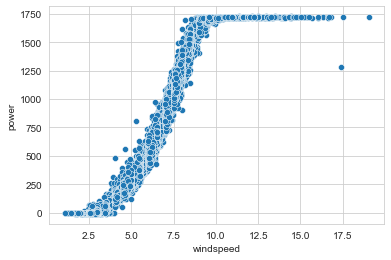

In [55]:
# potência em função da velocidade do vento após remoção de outliers
sns.scatterplot(data=df_merged, x='windspeed', y='power')

<AxesSubplot:xlabel='windspeed', ylabel='power'>

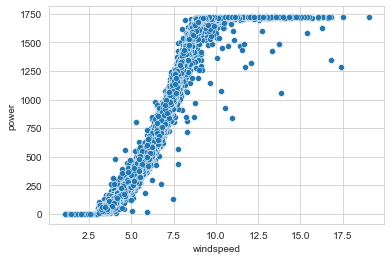

In [62]:
sns.scatterplot(data=df_media_horaria_erro_med, x='windspeed', y='power')

# Determinação da curva de potência
1. Determinação da curva de potência através do método descrito na IEC 61400 (sem turbulência)
2. Determinação da curva de potência através do uso de ML (regressão)
3. Determinação da curva de potência através do uso de ML (redes neurais artificiais)

In [63]:
df_merged.head()

,power,windspeed,bin,lower_inner
datetime_hourly,,,,
2018-10-01 00:00:00,359.452,5.508,"(5.5, 6.0]",261.703
2018-10-01 08:00:00,521.788,5.745,"(5.5, 6.0]",261.703
2018-10-01 14:00:00,530.812,5.962,"(5.5, 6.0]",261.703
2018-10-01 20:00:00,470.540,5.773,"(5.5, 6.0]",261.703
2018-10-01 21:00:00,470.937,5.873,"(5.5, 6.0]",261.703


Text(0, 0.5, 'Potência (kW)')

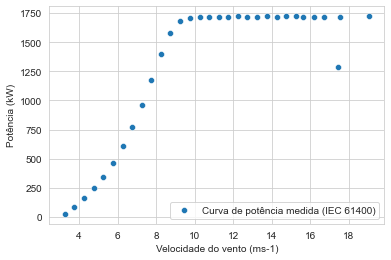

In [66]:
# 1.
# calc power curve
dx = 0.5
bins = np.arange(3.0, 26, dx)
left = df_merged.groupby(pd.cut(df_merged['windspeed'], bins)).mean()
right = df_original.groupby(pd.cut(df_original['WindSpeed'], bins)).mean()
df_power_curve = left.merge(right=right, how='left', left_index=True, right_index=True)
sns.scatterplot(data=df_power_curve, x='windspeed', y='power', label='Curva de potência medida (IEC 61400)')
#sns.scatterplot(data=df_power_curve, x='windspeed', y='Theoretical_Power_Curve (KWh)', label='Curva de potência teórica (Nordex N117)')
plt.xlabel('Velocidade do vento (ms-1)')
plt.ylabel('Potência (kW)')
# df_power_curve

In [67]:
df_media_horaria_erro_med.head()

,power,windspeed,cp
datetime_hourly,,,
2018-10-01 00:00:00,359.452,5.508,0.010
2018-10-01 01:00:00,85.282,3.720,0.003
2018-10-01 02:00:00,86.682,3.763,0.004
2018-10-01 03:00:00,197.393,4.395,0.007
2018-10-01 04:00:00,359.057,5.242,0.010


In [68]:
# 2.
model_ols = smf.ols(formula='power ~ windspeed', data=df_merged)
res_ols = model_ols.fit()
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 1.142e+05
Date:                Fri, 14 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:17:13   Log-Likelihood:                -76069.
No. Observations:               11612   AIC:                         1.521e+05
Df Residuals:                   11610   BIC:                         1.522e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -710.3455      4.104   -173.102      0.000    -718.389    -702.302
windspeed    225.3254      0.667    337.940      0.000     224.018     226.632
==============================================================================
Omnibus:                     2308.572   Durbin-Watson:                   0.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27053.840
Skew:                          -0.614   Prob(JB):                         0.00
Kurtosis:                      10.376   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

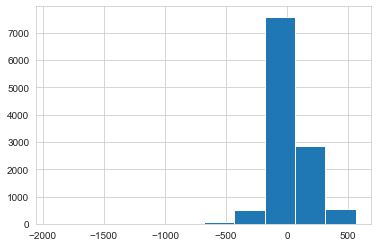

In [69]:
res_ols.resid.hist()

In [70]:
res_ols.resid.to_csv('res_ols.csv')
res_ols.resid

datetime_hourly
2018-10-01 00:00:00     -171.370
2018-10-01 08:00:00      -62.361
2018-10-01 14:00:00     -102.158
2018-10-01 20:00:00     -119.993
2018-10-01 21:00:00     -142.129
                         ...    
2019-08-08 09:00:00   -1,351.239
2019-08-08 11:00:00   -1,330.080
2019-08-08 07:00:00   -1,929.683
2019-08-08 08:00:00   -1,524.604
2019-08-08 10:00:00   -1,861.164
Length: 11612, dtype: float64

In [71]:
pandas2ri.activate()

shapiro_francia = importr('nortest')

valor = shapiro_francia.sf_test(res_ols.resid) # Passe para o teste shapiro francia os resíduos do modelo.
# p_value >= 0.05 tem aderência à normalidade
print(f'O valor da abscisa correspondente é: {valor[0]}')
print(f'O valor do p-value é: {valor[1]}')
print(f'O nome do método é: {valor[2]}')
print(f'O valor dos resíduos são: {valor[0]}')


#The Shapiro-Wilks test for normality is one of three general normality tests designed to detect all departures 
#from normality.  It is comparable in power to the other two tests.
#The test rejects the hypothesis of normality when the p-value is less than or equal to 0.05.  
#Failing the normality test allows you to state with 95% confidence the data does not fit the normal distribution.
#Passing the normality test only allows you to state no significant departure from normality was found.

R[write to console]: Error in (function (x)  : sample size must be between 5 and 5000



RRuntimeError: Error in (function (x)  : sample size must be between 5 and 5000


In [72]:
# box cox transformation
train = df_merged.query('power > 0').copy()
y_hat, lmbda = stats.boxcox(train['power'].values)
train['power_hat'] = y_hat
train.head()

,power,windspeed,bin,lower_inner,power_hat
datetime_hourly,,,,,
2018-10-01 00:00:00,359.452,5.508,"(5.5, 6.0]",261.703,20.049
2018-10-01 08:00:00,521.788,5.745,"(5.5, 6.0]",261.703,23.296
2018-10-01 14:00:00,530.812,5.962,"(5.5, 6.0]",261.703,23.456
2018-10-01 20:00:00,470.540,5.773,"(5.5, 6.0]",261.703,22.351
2018-10-01 21:00:00,470.937,5.873,"(5.5, 6.0]",261.703,22.359


In [73]:
model_ols_bc = smf.ols(formula='power_hat ~ windspeed', data=train)
res_ols_bc = model_ols_bc.fit()
res_ols_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              power_hat   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 7.053e+04
Date:                Fri, 14 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:20:16   Log-Likelihood:                -27361.
No. Observations:               10287   AIC:                         5.473e+04
Df Residuals:                   10285   BIC:                         5.474e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8532      0.101    -28.277      0.000      -3.051      -2.655
windspeed      4.1391      0.016    265.580      0.000       4.109       4.170
==============================================================================
Omnibus:                     6149.152   Durbin-Watson:                   0.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            82646.540
Skew:                          -2.642   Prob(JB):                         0.00
Kurtosis:                      15.841   Cond. No.                         19.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

datetime_hourly
2018-10-01 00:00:00     0.102
2018-10-01 08:00:00     2.370
2018-10-01 14:00:00     1.633
2018-10-01 20:00:00     1.308
2018-10-01 21:00:00     0.902
                        ...  
2019-08-08 09:00:00   -29.488
2019-08-08 11:00:00   -29.119
2019-08-08 07:00:00   -36.064
2019-08-08 08:00:00   -32.644
2019-08-08 10:00:00   -38.878
Length: 10287, dtype: float64

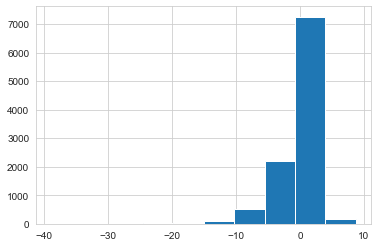

In [74]:
res_ols_bc.resid.hist()
res_ols_bc.resid.to_csv('res_ols_bc.csv')
res_ols_bc.resid

<AxesSubplot:xlabel='windspeed', ylabel='power_hat'>

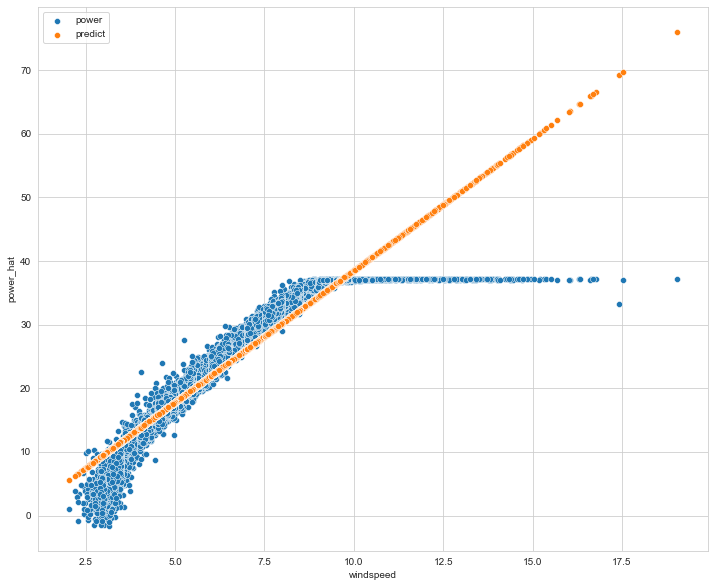

In [230]:
df_train_bc_predict_01 = train.copy()
df_train_bc_predict_01['predict'] = res_ols_bc.predict(df_train_bc_predict_01)

fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=df_train_bc_predict_01, x='windspeed', y='power_hat', label='power')
sns.scatterplot(data=df_train_bc_predict_01, x='windspeed', y='predict', label='predict')

In [83]:
valor_bc = shapiro_francia.sf_test(res_ols_bc.resid) # Passe para o teste shapiro francia os resíduos do modelo.
# p_value >= 0.05 tem aderência à normalidade
print(f'O valor da abscisa correspondente é: {valor_bc[0]}')
print(f'O valor do p-value é: {valor_bc[1]}')
print(f'O nome do método é: {valor_bc[2]}')
print(f'O valor dos resíduos são: {valor_bc[0]}')

R[write to console]: Error in (function (x)  : sample size must be between 5 and 5000



RRuntimeError: Error in (function (x)  : sample size must be between 5 and 5000


In [75]:
# criando dummies com a velocidade do vento
df_merged.head()

,power,windspeed,bin,lower_inner
datetime_hourly,,,,
2018-10-01 00:00:00,359.452,5.508,"(5.5, 6.0]",261.703
2018-10-01 08:00:00,521.788,5.745,"(5.5, 6.0]",261.703
2018-10-01 14:00:00,530.812,5.962,"(5.5, 6.0]",261.703
2018-10-01 20:00:00,470.540,5.773,"(5.5, 6.0]",261.703
2018-10-01 21:00:00,470.937,5.873,"(5.5, 6.0]",261.703


In [76]:
df_merged_dummies = pd.get_dummies(df_merged, columns=['bin'])
df_merged_dummies.head(1)

,power,windspeed,lower_inner,"bin_(0.0, 0.5]","bin_(0.5, 1.0]","bin_(1.0, 1.5]","bin_(1.5, 2.0]","bin_(2.0, 2.5]","bin_(2.5, 3.0]","bin_(3.0, 3.5]",...,"bin_(19.5, 20.0]","bin_(20.0, 20.5]","bin_(20.5, 21.0]","bin_(21.0, 21.5]","bin_(21.5, 22.0]","bin_(22.0, 22.5]","bin_(22.5, 23.0]","bin_(23.0, 23.5]","bin_(23.5, 24.0]","bin_(24.0, 24.5]"
datetime_hourly,,,,,,,,,,,,,,,,,,,,,
2018-10-01,359.452,5.508,261.703,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df_merged_dummies.columns = [c.replace('(', '').replace(']', '').replace(' ','').replace('.','').replace(',','_') for c in df_merged_dummies.columns]
df_merged_dummies.head(1)

,power,windspeed,lower_inner,bin_00_05,bin_05_10,bin_10_15,bin_15_20,bin_20_25,bin_25_30,bin_30_35,...,bin_195_200,bin_200_205,bin_205_210,bin_210_215,bin_215_220,bin_220_225,bin_225_230,bin_230_235,bin_235_240,bin_240_245
datetime_hourly,,,,,,,,,,,,,,,,,,,,,
2018-10-01,359.452,5.508,261.703,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
all_columns = [item for item in df_merged_dummies.columns if item not in ['power', 'windspeed', 'lower_inner']]
my_formula = "power ~ " + "+".join(all_columns)
model_ols_dummy = smf.ols(formula=my_formula, data=df_merged_dummies)
res_ols_dummy = model_ols_dummy.fit()
res_ols_dummy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 2.641e+04
Date:                Fri, 14 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:21:28   Log-Likelihood:                -64569.
No. Observations:               11612   AIC:                         1.292e+05
Df Residuals:                   11577   BIC:                         1.295e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1111.0026      3.764    295.138      0.000    1103.624    1118.381
bin_00_05    2.694e-12   1.34e-13     20.033      0.000    2.43e-12    2.96e-12
bin_05_10     8.07e-13   4.46e-14     18.088      0.000     7.2e-13    8.94e-13
bin_10_15   -1115.6985     13.584    -82.131      0.000   -1142.326   -1089.071
bin_15_20   -1116.1051      6.205   -179.857      0.000   -1128.269   -1103.941
bin_20_25   -1115.8290      4.776   -233.652      0.000   -1125.190   -1106.468
bin_25_30   -1111.5758      4.352   -255.425      0.000   -1120.106   -1103.045
bin_30_35   -1085.1417      4.291   -252.872      0.000   -1093.553   -1076.730
bin_35_40   -1026.6920      4.291   -239.283      0.000   -1035.103   -1018.282
bin_40_45    -948.4959      4.292   -221.000      0.000    -956.909    -940.083
bin_45_50    -862.9916      4.281   -201.594      0.000    -871.383    -854.600
bin_50_55    -764.9008      4.230   -180.812      0.000    -773.193    -756.609
bin_55_60    -648.5819      4.261   -152.207      0.000    -656.934    -640.229
bin_60_65    -505.8740      4.294   -117.807      0.000    -514.291    -497.457
bin_65_70    -338.3884      4.370    -77.437      0.000    -346.954    -329.823
bin_70_75    -147.2170      4.443    -33.135      0.000    -155.926    -138.508
bin_75_80      65.1116      4.581     14.214      0.000      56.132      74.091
bin_80_85     285.2499      4.678     60.979      0.000     276.081     294.419
bin_85_90     470.4621      4.857     96.869      0.000     460.942     479.982
bin_90_95     569.1699      5.331    106.763      0.000     558.720     579.620
bin_95_100    598.3950      5.831    102.622      0.000     586.965     609.825
bin_100_105   605.7447      6.508     93.080      0.000     592.988     618.501
bin_105_110   608.6157      7.471     81.464      0.000     593.971     623.260
bin_110_115   608.8723      8.475     71.840      0.000     592.259     625.486
bin_115_120   608.5963      9.073     67.079      0.000     590.812     626.381
bin_120_125   610.1003      9.363     65.162      0.000     591.748     628.453
bin_125_130   609.1301     10.501     58.006      0.000     588.546     629.714
bin_130_135   608.4198     13.880     43.835      0.000     581.213     635.627
bin_135_140   609.4946     13.309     45.796      0.000     583.407     635.582
bin_140_145   608.7520     16.249     37.463      0.000     576.901     640.603
bin_145_150   609.7251     18.839     32.365      0.000     572.798     646.652
bin_150_155   609.4647     27.637     22.053      0.000     555.292     663.637
bin_155_160   606.7691     43.453     13.964      0.000     521.593     691.945
bin_160_165   608.1270     30.841     19.718      0.000     547.673     668.581
bin_165_170   606.4618     30.841     19.664      0.000     546.008     666.916
bin_170_175   174.1374     61.337      2.83

datetime_hourly
2018-10-01 00:00:00   -102.969
2018-10-01 08:00:00     59.368
2018-10-01 14:00:00     68.391
2018-10-01 20:00:00      8.119
2018-10-01 21:00:00      8.516
                        ...   
2019-08-08 09:00:00      2.662
2019-08-08 11:00:00      4.669
2019-08-08 07:00:00     -0.000
2019-08-08 08:00:00     -0.000
2019-08-08 10:00:00     -0.000
Length: 11612, dtype: float64

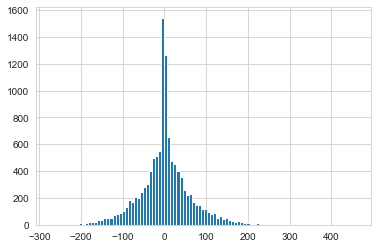

In [79]:
res_ols_dummy.resid.hist(bins=100)
res_ols_dummy.resid.to_csv('res_ols_dummy.csv')
res_ols_dummy.resid

<AxesSubplot:xlabel='windspeed', ylabel='power'>

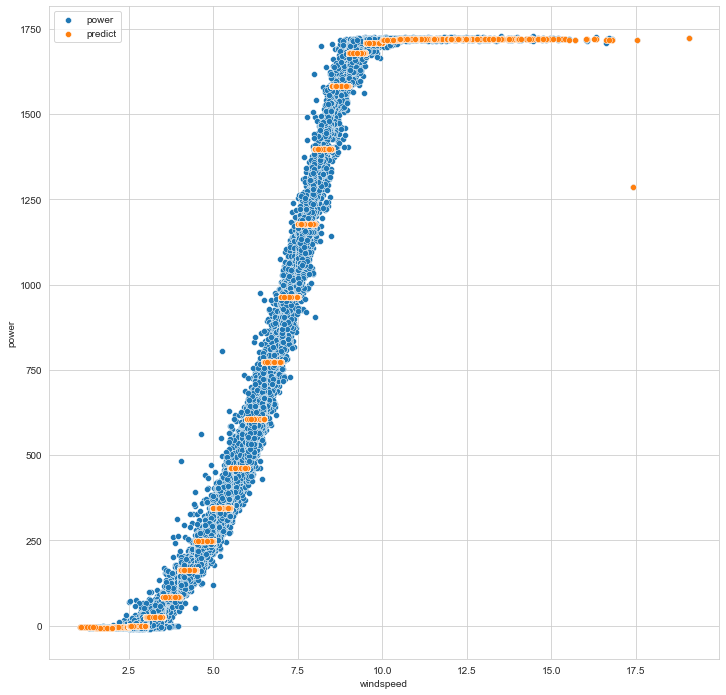

In [80]:
#df_test['predict'] = 
df_merged_dummies_predict = df_merged_dummies.copy()
df_merged_dummies_predict['predict'] = res_ols_dummy.predict(df_merged_dummies_predict)

fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(data=df_merged_dummies_predict, x='windspeed', y='power', label='power')
sns.scatterplot(data=df_merged_dummies_predict, x='windspeed', y='predict', label='predict')

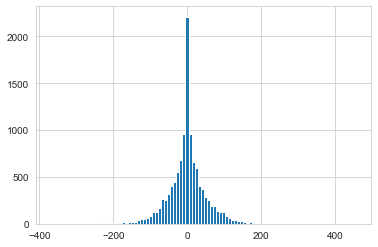

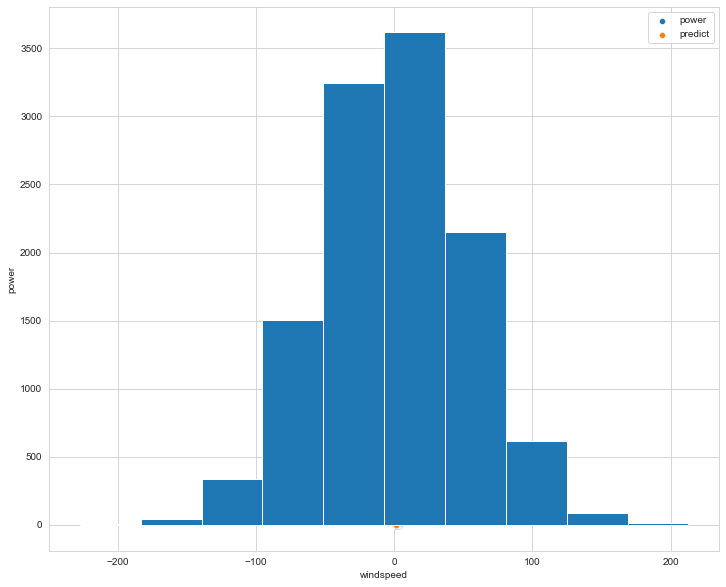

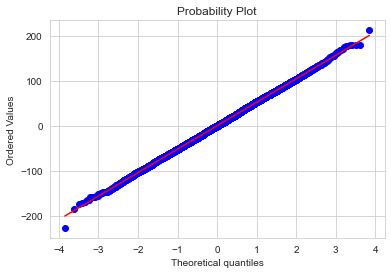

omnibus        0.780
Shapiro-Wilk   0.779
Lilliefors     0.371
KS             0.784
dtype: float64
Data are normally distributed


C:\Users\renat\AppData\Local\Temp\ipykernel_18268\2251580360.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pVals = pd.Series()
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     8616.
Date:                Fri, 14 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:15:10   Log-Likelihood:                -62379.
No. Observations:               11612   AIC:                         1.251e+05
Df Residuals:                   11460   BIC:                         1.262e+05
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1060.0207      1.634    648.615      0.000    1056.817    1063.224
bin_00_01    2.005e-13   8.39e-14      2.389      0.017     3.6e-14    3.65e-13
bin_01_02     4.88e-12   8.55e-14     57.093      0.000    4.71e-12    5.05e-12
bin_02_03    8.465e-14   7.12e-14      1.188      0.235    -5.5e-14    2.24e-13
bin_03_04    3.871e-13   6.72e-14      5.758      0.000    2.55e-13    5.19e-13
bin_04_05    -2.99e-12   9.36e-14    -31.949      0.000   -3.17e-12   -2.81e-12
bin_05_06   -1.795e-12   6.43e-14    -27.918      0.000   -1.92e-12   -1.67e-12
bin_06_07    1.616e-12   8.87e-14     18.221      0.000    1.44e-12    1.79e-12
bin_07_08       -2e-12   9.95e-14    -20.094      0.000    -2.2e-12   -1.81e-12
bin_08_09   -4.356e-12   8.81e-14    -49.469      0.000   -4.53e-12   -4.18e-12
bin_09_10   -2.898e-12   9.28e-14    -31.222      0.000   -3.08e-12   -2.72e-12
bin_10_11   -1064.8782     36.872    -28.880      0.000   -1137.154    -992.602
bin_11_12   -1064.1266     26.098    -40.774      0.000   -1115.284   -1012.969
bin_12_13   -1064.7863     30.121    -35.350      0.000   -1123.829   -1005.744
bin_13_14   -1064.8530     17.441    -61.053      0.000   -1099.041   -1030.665
bin_14_15   -1064.8670     26.098    -40.802      0.000   -1116.024   -1013.710
bin_15_16   -1065.2629     11.485    -92.754      0.000   -1087.775   -1042.751
bin_16_17   -1065.0821      9.980   -106.726      0.000   -1084.644   -1045.520
bin_17_18   -1064.8472      9.650   -110.342      0.000   -1083.764   -1045.931
bin_18_19   -1065.0889     10.346   -102.943      0.000   -1085.370   -1044.808
bin_19_20   -1065.2743      7.619   -139.811      0.000   -1080.210   -1050.339
bin_20_21   -1065.3002      7.936   -134.239      0.000   -1080.856   -1049.745
bin_21_22   -1065.1856      6.312   -168.745      0.000   -1077.559   -1052.812
bin_22_23   -1065.1447      6.049   -176.079      0.000   -1077.002   -1053.287
bin_23_24   -1065.1982      5.295   -201.183      0.000   -1075.577   -1054.820
bin_24_25   -1064.0220      4.869   -218.525      0.000   -1073.566   -1054.478
bin_25_26   -1064.1163      4.836   -220.040      0.000   -1073.596   -1054.637
bin_26_27   -1063.1352      4.852   -219.092      0.000   -1072.647   -1053.624
bin_27_28   -1062.6362      4.264   -249.234      0.000   -1070.994   -1054.279
bin_28_29   -1059.1558      4.233   -250.223      0.000   -1067.453   -1050.859
bin_29_30   -1055.4012      4.295   -245.716      0.000   -1063.820   -1046.982
bin_30_31   -1051.2324      4.253   -247.159      0.000   -1059.570   -1042.895
bin_31_32   -1042.9432      4.306   -242.210      0.000   -1051.384   -1034.503
bin_32_33   -1035.1079      4.136   -250.271      0.000   -1043.215   -1027.001
bin_33_34   -1022.9717      4.253   -240.515      0.000   -1031.309   -1014.635
bin_34_35   -1018.3703      4.295   -237.09

In [202]:
# nova tentativa com bins menores
dx = 0.1
bins = np.arange(0, 25, dx)
df_binned_01 = df_merged.copy()
df_binned_01['bin'] = pd.cut(df_binned_01["windspeed"], bins)
df_binned_01

df_merged_dummies_01 = pd.get_dummies(df_binned_01, columns=['bin'])
df_merged_dummies_01.columns = [c.replace('(', '').replace(']', '').replace(' ','').replace('.','').replace(',','_') for c in df_merged_dummies_01.columns]

all_columns_01 = [item for item in df_merged_dummies_01.columns if item not in ['power', 'windspeed', 'lower_inner']]
my_formula_01 = "power ~ " + "+".join(all_columns_01)
model_ols_dummy_01 = smf.ols(formula=my_formula_01, data=df_merged_dummies_01)
res_ols_dummy_01 = model_ols_dummy_01.fit()
res_ols_dummy_01.summary()

res_ols_dummy_01.resid.hist(bins=100)

df_merged_dummies_predict_01 = df_merged_dummies_01.copy()
df_merged_dummies_predict_01['predict'] = res_ols_dummy_01.predict(df_merged_dummies_predict_01)

fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=df_merged_dummies_predict_01, x='windspeed', y='power', label='power')
sns.scatterplot(data=df_merged_dummies_predict_01, x='windspeed', y='predict', label='predict')

check_normality(res_ols_dummy_01.resid)
res_ols_dummy_01.summary()

In [84]:
df_merged_dummies_01.columns
array_predict = np.zeros(252)
array_predict[int(7.5/0.1)] = 1
#array_predict[1] = 1
df_serialize = pd.DataFrame([array_predict], columns=df_merged_dummies_01.columns)
df_serialize

res_ols_dummy_01.predict(df_serialize)
#https://mlatcl.github.io/deepnn/background/background-basis-functions.html

0   963.189
dtype: float64

In [447]:
# criando modelo usando redes neurais

#MLPRegressor(hidden_layer_sizes=(100,), 
#                               activation='relu', *, solver='adam', alpha=0.0001, 
#                               batch_size='auto', learning_rate='constant', 
#                               learning_rate_init=0.001, power_t=0.5, max_iter=200, 
#                               shuffle=True, random_state=None, tol=0.0001, verbose=False, 
#                               warm_start=False, momentum=0.9, nesterovs_momentum=True, 
#                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
#                               beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

df_merged_dropna = df_merged.dropna()

#sc = StandardScaler()
#df_merged_standardized = pd.DataFrame()
#df_merged_standardized[['power', 'windspeed']] = sc.fit_transform(df_merged_dropna[['power', 'windspeed']])
df_merged_standardized = df_merged_dropna.copy()

df_merged_standardized.loc[df_merged_standardized['power'] < 0, 'power'] = 0
X = df_merged_standardized['windspeed'].values.reshape((len(df_merged_standardized['windspeed'].values),1))
y = df_merged_standardized['power']
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)
# Accuracy metrics

def smape(a, f):
    #return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
    return np.mean(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))

def forecast_accuracy3(forecast, actual):
    from statsmodels.tsa.stattools import acf
    from sklearn.metrics import mean_absolute_percentage_error            
    
    #mape = mean_absolute_percentage_error(actual, forecast)    
    #mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE     
    mape = smape(actual, forecast)
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    #mpe = np.mean((forecast - actual)/actual)   # MPE
    mpe = 0
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast[:], actual[:])[0,1]   # corr    
    #mins = np.amin(np.hstack([forecast[:], 
    #                          actual[:]]), axis=1)
    #maxs = np.amax(np.hstack([forecast[:], 
    #                          actual[:]]), axis=1)
    #minmax = 1 - np.mean(mins/maxs)             # minmax
    minmax = 0
    acf1 = acf((forecast[:]-actual[:]))[0]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax, 'accuracy': 1-mape})
#for act in ['identity', 'logistic', 'tanh', 'relu']:
#    for sz in [10, 50, 100, 150, 200]:
        #regr = MLPRegressor(random_state=1, max_iter=450, activation='tanh', hidden_layer_sizes=(150,)).fit(X_train, y_train)
#        regr = MLPRegressor(random_state=1, max_iter=1000, activation=act, hidden_layer_sizes=(sz,)).fit(X_train, y_train)
        #regr.predict(X_test[:2])

#        print(f'{act} - {sz} - {regr.score(X_test, y_test)}')
#        print(forecast_accuracy3(regr.predict(X_test[:len(y_test)]), y_test.values))
        #print(forecast_accuracy3(regr.predict(X_test[:2]), y_test.values[:2]))
        #break
    #break
regr = MLPRegressor(random_state=1, max_iter=1000, activation='tanh', hidden_layer_sizes=(100,)).fit(X_train, y_train)

(11612, 1)
(11612,)


Text(0, 0.5, 'Erro')

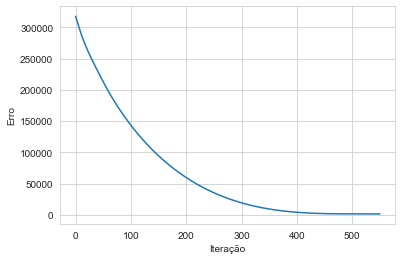

In [448]:
plt.plot(regr.loss_curve_)
plt.xlabel("Iteração")
plt.ylabel("Erro")

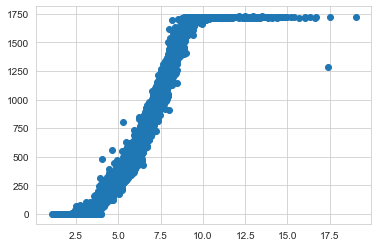

In [408]:
plt.scatter(X_train, y_train)

66.964340667818
0.3086855292256096
0.9849550259641997


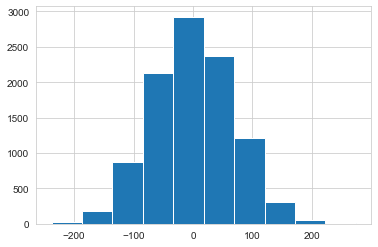

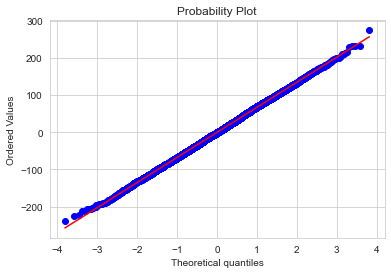

omnibus        0.176
Shapiro-Wilk   0.458
Lilliefors     0.228
KS             0.670
dtype: float64
Data are normally distributed
None
-0.8018183249684667


C:\Users\renat\AppData\Local\Temp\ipykernel_18268\2251580360.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pVals = pd.Series()
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [428]:
#df_power_curve
df_iec = df_merged_standardized.copy()

#df_iec['windspeed'] = X_test
df_iec = df_iec.merge(df_power_curve, left_on='bin', right_index=True)[['power_x', 'power_y']]
print(np.mean((df_iec['power_y'] - df_iec['power_x'])**2)**.5)  # RMSE
print(np.mean(np.abs(df_iec.query('power_x > 0')['power_y'] - df_iec.query('power_x > 0')['power_x'])/np.abs(df_iec.query('power_x > 0')['power_x'])))  # MAPE

from sklearn.metrics import r2_score
print(r2_score(df_iec.query('power_x > 0')['power_x'], df_iec.query('power_x > 0')['power_y']))

print(check_normality(df_iec.query('power_x > 0')['power_y'] - df_iec.query('power_x > 0')['power_x']))

Text(0, 0.5, 'Potência (kW)')

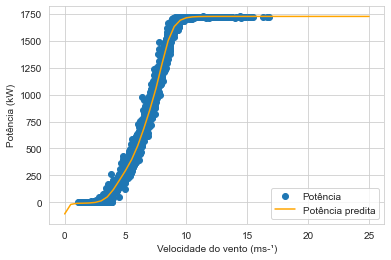

In [449]:
plt.scatter(X_test, y_test, label='Potência')
plt.plot(np.linspace(0,25,51), regr.predict(np.linspace(0,25,51).reshape((51,1))), color='orange', label='Potência predita')
plt.legend()
plt.xlabel('Velocidade do vento (ms-¹)')
plt.ylabel('Potência (kW)')

{'mape': 1.0666848313260931e+17, 'me': 23.518753987294783, 'mae': 57.83634400094301, 'mpe': 0, 'rmse': 190.8461255176253, 'acf1': 1.0, 'corr': 0.9427678605383256, 'minmax': 0, 'accuracy': -1.0666848313260931e+17}
{'mape': 0.5391248149002775, 'me': 8.752792405513744e-15, 'mae': 2.3589032338344422, 'mpe': 0, 'rmse': 3.4583057621101423, 'acf1': 1.0, 'corr': 0.9342046525792146, 'minmax': 0, 'accuracy': 0.4608751850997225}
{'mape': 1.1366986411627414e+17, 'me': 23.54003523041466, 'mae': 148.37312658953456, 'mpe': 0, 'rmse': 248.49563202363137, 'acf1': 1.0, 'corr': 0.8987599747153339, 'minmax': 0, 'accuracy': -1.1366986411627414e+17}
{'mape': 1.0708691943867802e+17, 'me': 23.51772475008652, 'mae': 71.23939931622397, 'mpe': 0, 'rmse': 196.66928603396326, 'acf1': 1.0, 'corr': 0.9391091362401996, 'minmax': 0, 'accuracy': -1.0708691943867802e+17}
{'mape': 0.5391248149002775, 'me': 8.752792405513744e-15, 'mae': 2.3589032338344422, 'mpe': 0, 'rmse': 3.4583057621101423, 'acf1': 1.0, 'corr': 0.93420

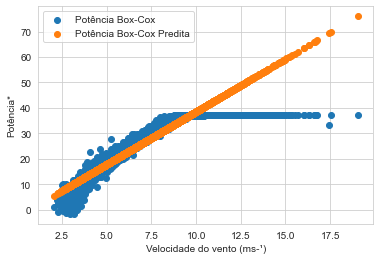

In [329]:
#plt.scatter(X_test, y_test)
#plt.plot(np.linspace(0,25,51), regr.predict(np.linspace(0,25,51).reshape((51,1))), color='orange')
#sns.scatterplot(data=df_merged_dummies_predict_01, x='windspeed', y='predict', label='predict')
print(forecast_accuracy3(df_merged_dummies_predict_01.predict.fillna(0).values, df_merged_dummies_predict_01.power.fillna(0).values))
print(forecast_accuracy3(res_ols_bc.predict(df_train_bc_predict_01.windspeed), df_train_bc_predict_01.power_hat.values))
print(forecast_accuracy3(res_ols.predict(df_merged.windspeed).fillna(0), df_merged.power.fillna(0).values))
print(forecast_accuracy3(res_ols_poly.predict(df_merged_poly_predict_01).fillna(0), df_merged_poly_predict_01.power.fillna(0).values))
print(forecast_accuracy3(res_ols_bc.predict(train.windspeed), train.power_hat.values))
plt.scatter(df_train_bc_predict_01.windspeed.values, df_train_bc_predict_01.power_hat.values, label='Potência Box-Cox')
plt.scatter(df_train_bc_predict_01.windspeed.values, res_ols_bc.predict(df_train_bc_predict_01), label='Potência Box-Cox Predita')
plt.xlabel('Velocidade do vento (ms-¹)')
plt.ylabel('Potência*')
plt.legend()
#res_ols_bc

0.2822148211476358


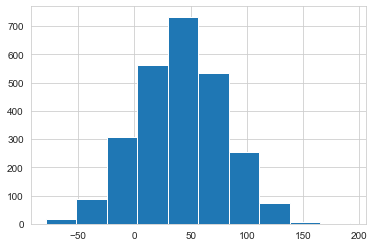

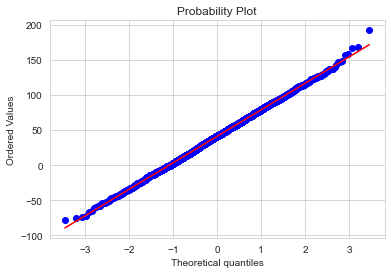

omnibus        0.815
Shapiro-Wilk   0.834
Lilliefors     0.480
KS             0.834
dtype: float64
Data are normally distributed
None


C:\Users\renat\AppData\Local\Temp\ipykernel_18268\2251580360.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pVals = pd.Series()


In [420]:
from sklearn.metrics import mean_absolute_percentage_error
#mean_absolute_percentage_error(y_test, regr.predict(X_test))
df_mape_rn = pd.DataFrame()
df_mape_rn['y_test'] = y_test
df_mape_rn['y_predict'] = regr.predict(X_test)
df_mape_rn['error'] =  np.abs(df_mape_rn['y_predict'] - df_mape_rn['y_test'])
df_mape_rn['error_abs'] = df_mape_rn['error'] / np.abs(df_mape_rn['y_test'])
#df_mape_rn.to_clipboard()
print(np.mean(df_mape_rn.query('y_test > 0')['error_abs']))
print(check_normality(df_mape_rn.query('y_test > 0')['error']))

152142.90430941732
Intercept   0.000
windspeed   0.000
dtype: float64
152007.09375917222
Intercept        0.000
windspeed        0.000
windspeed_quad   0.000
dtype: float64
139855.7536555293
Intercept        0.000
windspeed        0.000
windspeed_cub    0.000
windspeed_quad   0.000
dtype: float64
135507.97454881363
Intercept        0.000
windspeed        0.000
windspeed_cub    0.000
windspeed_quad   0.000
windspeed_p4     0.000
dtype: float64
132878.09236607564
Intercept        0.000
windspeed        0.000
windspeed_cub    0.000
windspeed_quad   0.000
windspeed_p4     0.000
windspeed_p5     0.000
dtype: float64
129697.05662631689
Intercept        0.000
windspeed        0.000
windspeed_cub    0.000
windspeed_quad   0.000
windspeed_p4     0.000
windspeed_p5     0.000
windspeed_p6     0.000
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.430e+05
Date:                Sat, 15 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:00:49   Log-Likelihood:                -64842.
No. Observations:               11612   AIC:                         1.297e+05
Df Residuals:                   11605   BIC:                         1.297e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1214.1076     29.688    -40.896      0.000   -1272.301   -1155.914
windspeed       1449.8470     29.361     49.380      0.000    1392.294    1507.400
windspeed_cub    136.2523      2.019     67.473      0.000     132.294     140.211
windspeed_quad  -649.5637     11.020    -58.945      0.000    -671.164    -627.963
windspeed_p4     -13.2121      0.192    -68.846      0.000     -13.588     -12.836
windspeed_p5       0.5932      0.009     65.663      0.000       0.575       0.611
windspeed_p6      -0.0100      0.000    -60.497      0.000      -0.010      -0.010
==============================================================================
Omnibus:                      574.798   Durbin-Watson:                   1.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2049.290
Skew:                           0.104   Prob(JB):                         0.00
Kurtosis:                       5.048   Cond. No.                     8.19e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.19e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

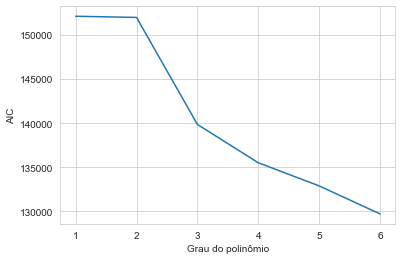

In [294]:
# modelo usando expansão em polinômios
df_poly = df_merged.copy()
df_poly = df_poly.drop(columns=['bin','lower_inner'])
df_poly['windspeed_bias'] = 1
df_poly['windspeed_quad'] = np.power(df_poly['windspeed'], 2)
df_poly['windspeed_cub'] = np.power(df_poly['windspeed'], 3)
df_poly['windspeed_p4'] = np.power(df_poly['windspeed'], 4)
df_poly['windspeed_p5'] = np.power(df_poly['windspeed'], 5)
df_poly['windspeed_p6'] = np.power(df_poly['windspeed'], 6)
df_poly['windspeed_p7'] = np.power(df_poly['windspeed'], 7)
df_poly.head()

formulas = [
    "power ~ windspeed",    
    "power ~ windspeed + windspeed_quad",
    "power ~ windspeed + windspeed_cub + windspeed_quad",
    "power ~ windspeed + windspeed_cub + windspeed_quad + windspeed_p4",
    "power ~ windspeed + windspeed_cub + windspeed_quad + windspeed_p4 + windspeed_p5",
    "power ~ windspeed + windspeed_cub + windspeed_quad + windspeed_p4 + windspeed_p5 + windspeed_p6",
    #"power ~ windspeed + windspeed_cub + windspeed_quad + windspeed_p4 + windspeed_p5 + windspeed_p6 + windspeed_p7",
    #"power ~ windspeed + windspeed_cub + windspeed_quad + windspeed_p4 + windspeed_p5 + windspeed_p6 + windspeed_p7"
]
res_aic = []
for f in formulas:
    #print(f)
    #my_formula_poly = "power ~ windspeed_bias + windspeed + windspeed_cub + windspeed_quad + windspeed_p4 + windspeed_p5 + windspeed_p6 + windspeed_p7"
    #model_ols_poly = smf.ols(formula=my_formula_poly, data=df_poly)
    model_ols_poly = smf.ols(formula=f, data=df_poly)
    res_ols_poly = model_ols_poly.fit()

    print(res_ols_poly.aic)
    print(res_ols_poly.pvalues)
    res_aic.append(res_ols_poly.aic)

plt.plot(range(1, len(res_aic)+1), res_aic)
plt.xlabel("Grau do polinômio")
plt.ylabel("AIC")
res_ols_poly.summary()

datetime_hourly
2018-10-01 00:00:00    -40.602
2018-10-01 08:00:00     50.692
2018-10-01 14:00:00     -9.586
2018-10-01 20:00:00     -9.400
2018-10-01 21:00:00    -40.755
                        ...   
2019-08-08 09:00:00    -85.245
2019-08-08 11:00:00    -69.989
2019-08-08 07:00:00   -607.116
2019-08-08 08:00:00   -186.178
2019-08-08 10:00:00    121.406
Length: 11612, dtype: float64

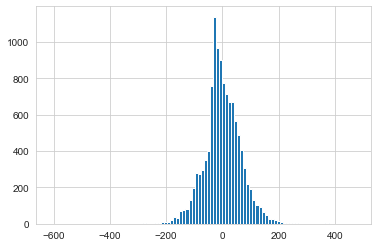

In [191]:
res_ols_poly.resid.hist(bins=100)
res_ols_poly.resid.to_csv('res_ols_poly.csv')
res_ols_poly.resid

<AxesSubplot:xlabel='windspeed', ylabel='power'>

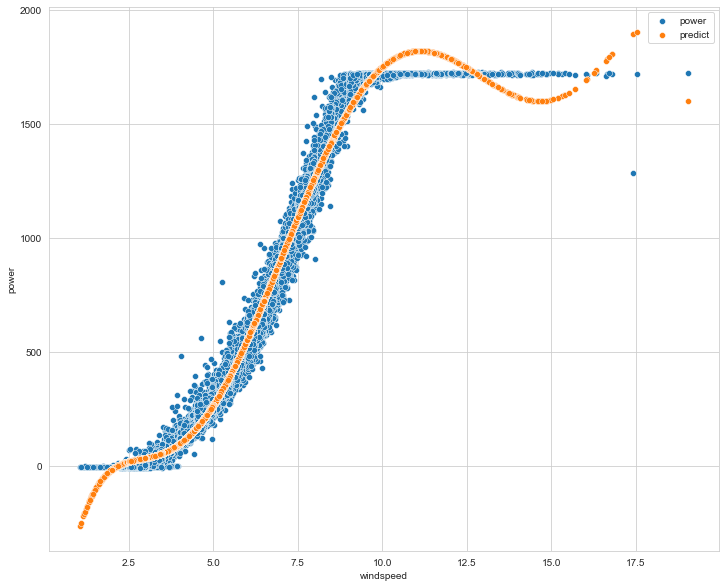

In [192]:
df_merged_poly_predict_01 = df_poly.copy()
df_merged_poly_predict_01['predict'] = res_ols_poly.predict(df_merged_poly_predict_01)

fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=df_merged_poly_predict_01, x='windspeed', y='power', label='power')
sns.scatterplot(data=df_merged_poly_predict_01, x='windspeed', y='predict', label='predict')

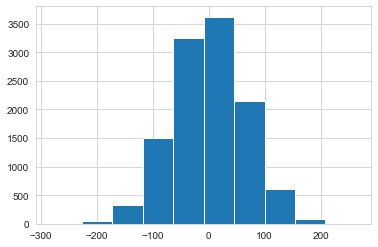

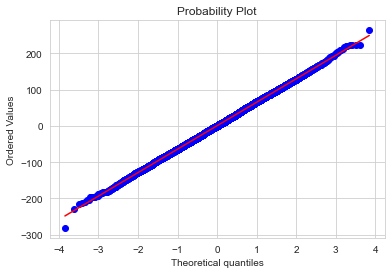

omnibus        0.780
Shapiro-Wilk   0.779
Lilliefors     0.371
KS             0.784
dtype: float64
Data are normally distributed


C:\Users\renat\AppData\Local\Temp\ipykernel_18268\2251580360.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pVals = pd.Series()
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [231]:
check_normality(res_ols_poly.resid)

D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


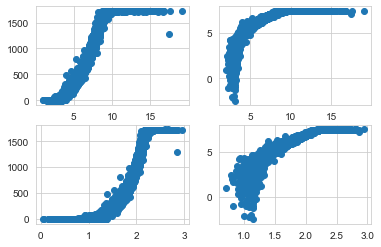

In [217]:
#df_merged.head()
df_merged_transformed = df_merged.copy()
df_merged_transformed['log_power'] = np.log(df_merged_transformed['power'])
df_merged_transformed['log_windspeed'] = np.log(df_merged_transformed['windspeed'])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.scatter(df_merged_transformed['windspeed'], df_merged_transformed['power'])
ax2.scatter(df_merged_transformed['windspeed'], df_merged_transformed['log_power'])
ax3.scatter(df_merged_transformed['log_windspeed'], df_merged_transformed['power'])
ax4.scatter(df_merged_transformed['log_windspeed'], df_merged_transformed['log_power'])

In [226]:
model_ols_log_power = smf.ols(formula="log_power ~ log_windspeed", data=df_merged_transformed.dropna())
res_ols_log_power = model_ols_log_power.fit()
res_ols_log_power.summary()

D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_power   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 14 Oct 2022   Prob (F-statistic):                nan
Time:                        12:39:39   Log-Likelihood:                    nan
No. Observations:               10324   AIC:                               nan
Df Residuals:                   10322   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept           -inf        nan        nan        nan         nan         nan
log_windspeed        inf        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='windspeed', ylabel='log_power'>

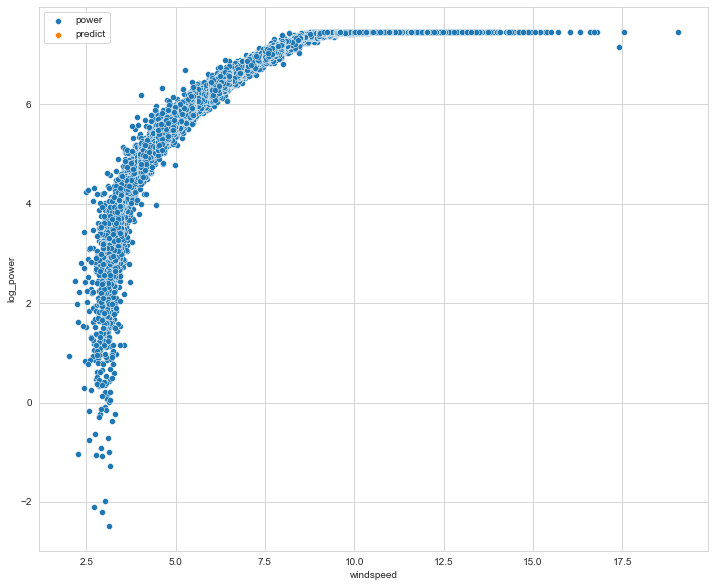

In [228]:
df_merged_transformed_predict_01 = df_merged_transformed.copy()
df_merged_transformed_predict_01['predict'] = res_ols_log_power.predict(df_merged_transformed_predict_01)

fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=df_merged_transformed_predict_01, x='windspeed', y='log_power', label='power')
sns.scatterplot(data=df_merged_transformed_predict_01, x='log_windspeed', y='predict', label='predict')

In [200]:
# heterocedasticidade dos residuos
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(res_ols_poly.resid, res_ols_poly.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 1550.8721919313443),
 ('p-value', 0.0),
 ('f-value', 298.14205277148653),
 ('f p-value', 0.0)]

In [199]:
# normalidade dos residuos
from statsmodels.stats.diagnostic import kstest_normal
names = ['ksstatfloat', 'p-value']
kstest_normal(res_ols_poly.resid, dist='norm')


(0.051837578741912776, 0.0009999999999998899)

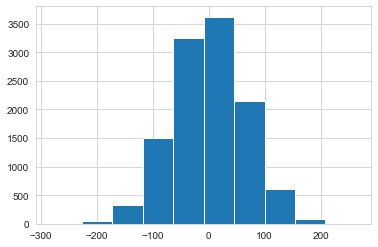

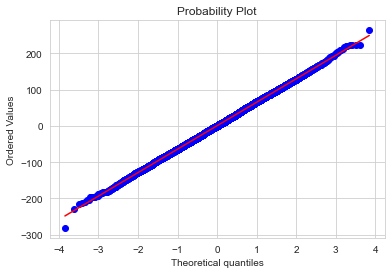

omnibus        0.780
Shapiro-Wilk   0.779
Lilliefors     0.371
KS             0.784
dtype: float64
Data are normally distributed


C:\Users\renat\AppData\Local\Temp\ipykernel_18268\2251580360.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pVals = pd.Series()
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [198]:
def check_normality(data):
    '''Check if the distribution is normal.'''
    # Generate and show a distribution
    numData = len(data)
    myMean = np.mean(data)
    mySD = np.std(data)
    
    # To get reproducable values, I provide a seed value
    np.random.seed(987654321)   
    
    data = stats.norm.rvs(myMean, mySD, size=numData)
    plt.hist(data)
    plt.show()

    # --- >>> START stats <<< ---
    # Graphical test: if the data lie on a line, they are pretty much
    # normally distributed
    _ = stats.probplot(data, plot=plt)
    plt.show()

    pVals = pd.Series()
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.
    _, pVals['omnibus'] = stats.normaltest(data)

    # Shapiro-Wilk test
    _, pVals['Shapiro-Wilk'] = stats.shapiro(data)
    
    # Or you can check for normality with Lilliefors-test
    ksStats, pVals['Lilliefors'] = kstest_normal(data)
    
    # Alternatively with original Kolmogorov-Smirnov test
    _, pVals['KS'] = stats.kstest((data-np.mean(data))/np.std(data,ddof=1), 'norm')
    
    print(pVals)
    if pVals['omnibus'] > 0.05:
        print('Data are normally distributed')

check_normality(res_ols_poly.resid)

In [136]:
#multicolinearidade
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
df_poly_vif = df_merged_dummies_01.dropna().drop(columns=['power'])
vif_data = pd.DataFrame()
vif_data["feature"] = df_poly_vif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_poly_vif.values, i)
                          for i in range(len(df_poly_vif.columns))]
  
print(vif_data)

D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


         feature       VIF
0      windspeed 6,654.507
1    lower_inner       inf
2      bin_00_01       NaN
3      bin_01_02       NaN
4      bin_02_03       NaN
..           ...       ...
246  bin_244_245       NaN
247  bin_245_246       NaN
248  bin_246_247       NaN
249  bin_247_248       NaN
250  bin_248_249       NaN

[251 rows x 2 columns]


In [115]:
from sklearn.preprocessing import PolynomialFeatures
trans = PolynomialFeatures(degree=2)
data = trans.fit_transform(df_poly['windspeed'].values.reshape(df_poly['windspeed'].shape[0],1))
print(data)

[[  1.           5.50833333  30.34173611]
 [  1.           5.745       33.005025  ]
 [  1.           5.96166667  35.54146944]
 ...
 [  1.          17.42       303.4564    ]
 [  1.          17.54       307.6516    ]
 [  1.          19.05666667 363.15654444]]


# Séries temporais

,windspeed
count,50530.000000
mean,7.557947
std,4.227181
min,0.000000
25%,4.200000
50%,7.100000
75%,10.300000
max,25.210000


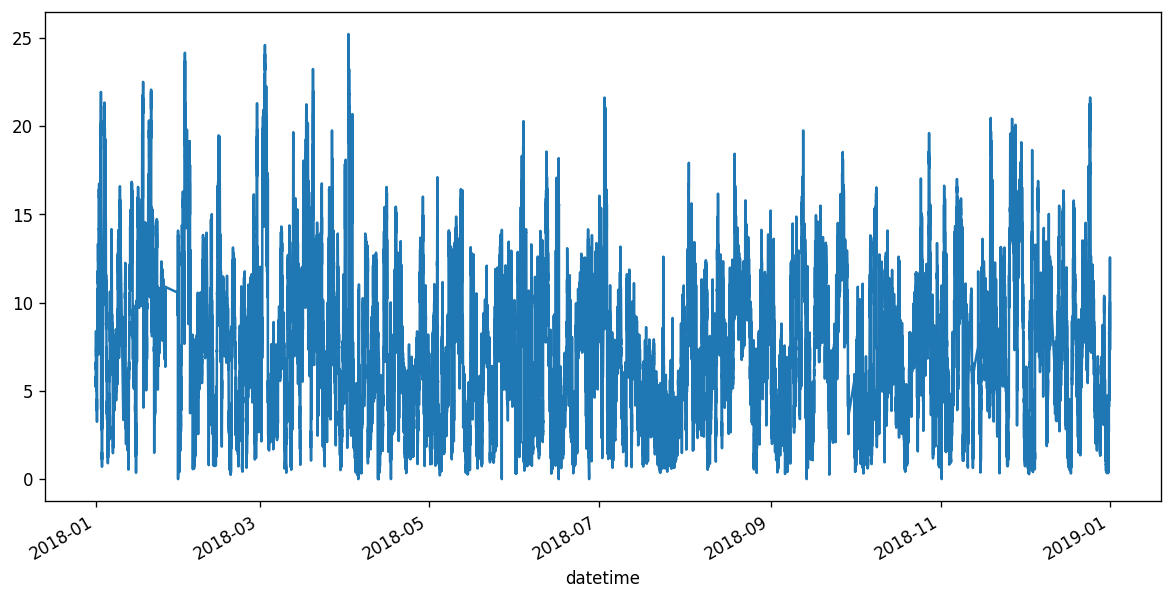

In [448]:
# predizer a velocidade do vento para 24h adiante
df_serie_temporal = df[['windspeed']].copy()
#df_serie_temporal.to_csv('serie_temporal.csv')
fig_st, axst = plt.subplots(figsize=(12,6))
df_serie_temporal['windspeed'].plot()
df_serie_temporal.describe()

<AxesSubplot:xlabel='datetime'>

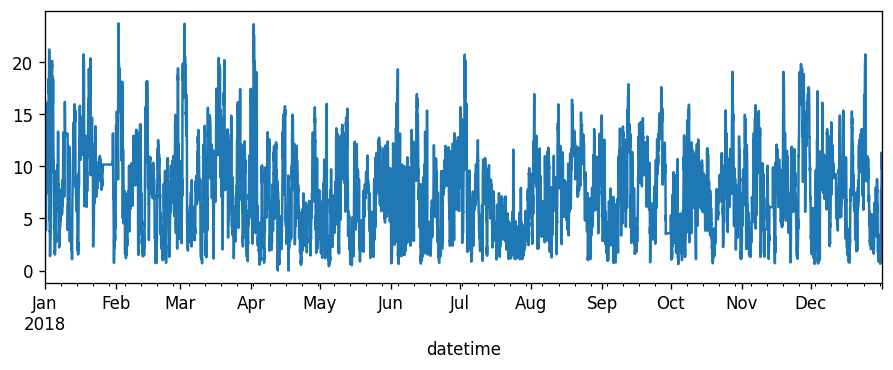

In [449]:
df_serie_temporal = df_serie_temporal.resample('H').mean().ffill()
df_serie_temporal.to_csv('serie_temporal.csv')
df_serie_temporal.head()
df_serie_temporal['windspeed'].plot()

In [450]:
df_serie_temporal['windspeed'].isna().sum()

0

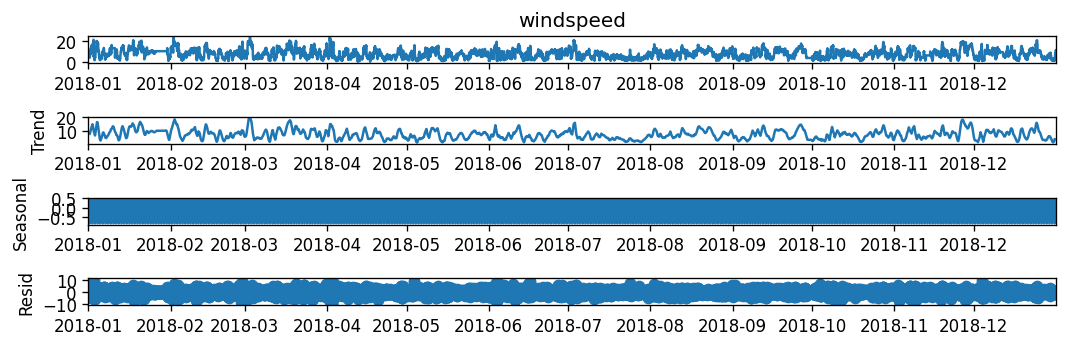

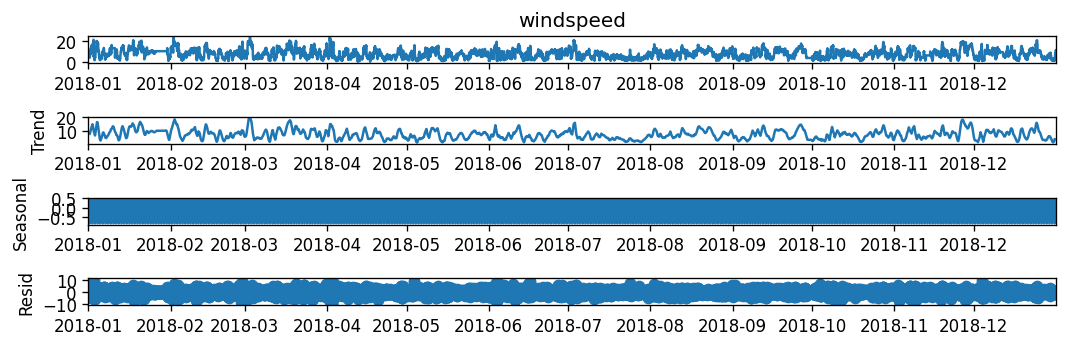

In [452]:
result = seasonal_decompose(x=df_serie_temporal['windspeed'].dropna(), model='additive')
result.plot()

In [334]:
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm

adf_test = pm.arima.ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df_serie_temporal.diff(1).dropna())
print(p_val)
print(should_diff)
kpss_test = pm.arima.KPSSTest(alpha=0.05)
p_val, should_diff = kpss_test.should_diff(df_serie_temporal.diff(1).dropna())
print(p_val)
print(should_diff)
pp_test = pm.arima.PPTest(alpha=0.05)
p_val, should_diff = pp_test.should_diff(df_serie_temporal.diff(1).dropna())
print(p_val)
print(should_diff)

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(df_serie_temporal.diff(1).dropna(), test='adf')  # -> 0
print(n_adf)
# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(df_serie_temporal.diff(1).dropna(), test='kpss')  # -> 0
print(n_kpss)
# Or a PP test:
n_pp = ndiffs(df_serie_temporal.diff(1).dropna(), test='pp')  # -> 0
print(n_pp)


ns_kpss = nsdiffs(df_serie_temporal, m=2)  # -> 0
print(f'ns_diffs {ns_kpss}')

assert n_adf == n_kpss == n_pp == 0

0.01
False
0.1
False
0.01
False
0
0
0
ns_diffs 0


In [335]:
# biblioteca adfuller
from statsmodels.tsa.stattools import adfuller

#result = adfuller(df_serie_temporal['windspeed'], autolag='AIC')
result = adfuller(df_serie_temporal['windspeed'].diff(1).dropna(), autolag='AIC')

print('Test statistic: ' , result[0])
print('p-value: '  ,result[1])
print('Critical Values:' ,result[4])

# como p_value < 0.05, a série temporal é estacionária

sm.stats.acorr_ljungbox(df_serie_temporal['windspeed'].diff(1).dropna(), lags=None)

Test statistic:  -12.708701378897896
p-value:  1.0414470348178088e-23
Critical Values: {'1%': -3.4333490866177807, '5%': -2.862864895984805, '10%': -2.5674753077239294}


,lb_stat,lb_pvalue
1,6.049461,0.013911
2,9.197251,0.010066
3,9.874216,0.019666
4,9.895863,0.042219
5,13.059659,0.022826
6,24.093248,0.000502
7,25.288857,0.000674
8,25.290935,0.001388
9,32.562071,0.000159
10,35.258219,0.000113


{'period1': 23.9972602739726, 'freq1': 0.041671423678502115, 'power1': 102.17766883189485, 'period2': 11.9986301369863, 'freq2': 0.08334284735700423, 'power2': 92.72020701743118, 'period3': 10.033218785796105, 'freq3': 0.099668911976253, 'power3': 41.009451414808126, 'period4': 13.45468509984639, 'freq4': 0.07432355291699966, 'power4': 37.121388284769075, 'period5': 2.866164921465969, 'freq5': 0.34889827605891083, 'power5': 34.26898216462899, 'period6': 5.695058517555267, 'freq6': 0.17559082086996233, 'power6': 33.97749413743902, 'period7': 9.469189189189189, 'freq7': 0.10560566274688891, 'power7': 33.516094134678745}


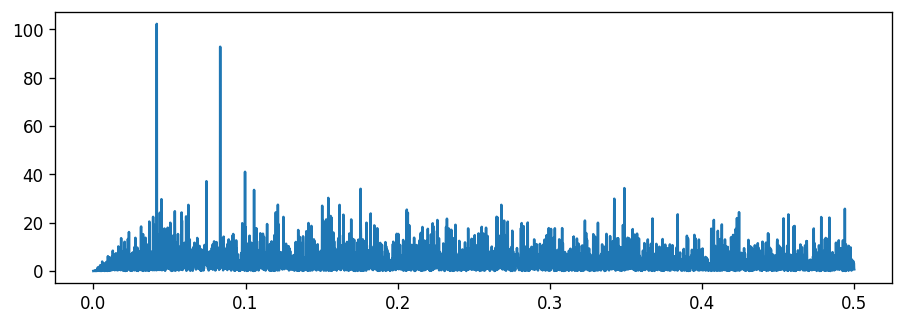

In [405]:
# seasonality with sarima model
from scipy import signal
def my_periodogram(v):
    f, Pxx = signal.periodogram(v.dropna())
    plt.plot(f, Pxx)
    top_3_periods = {}

    # get indices for 3 highest Pxx values
    top3_freq_indices = np.flip(np.argsort(Pxx), 0)[0:7]

    # use indices from previous step to
    # get 3 frequencies with highest power
    freqs = f[top3_freq_indices]

    # use same indices to get powers as well
    power = Pxx[top3_freq_indices]

    # we are interested in period and it is calculated as 1/frequency 
    periods = 1 / np.array(freqs)

    # populate dict with calculated values
    top_3_periods['period1'] = periods[0]
    top_3_periods['freq1'] = freqs[0]
    top_3_periods['power1'] = power[0]

    top_3_periods['period2'] = periods[1]
    top_3_periods['freq2'] = freqs[1]
    top_3_periods['power2'] = power[1]

    top_3_periods['period3'] = periods[2]
    top_3_periods['freq3'] = freqs[2]
    top_3_periods['power3'] = power[2]

    top_3_periods['period4'] = periods[3]
    top_3_periods['freq4'] = freqs[3]
    top_3_periods['power4'] = power[3]

    top_3_periods['period5'] = periods[4]
    top_3_periods['freq5'] = freqs[4]
    top_3_periods['power5'] = power[4]

    top_3_periods['period6'] = periods[5]
    top_3_periods['freq6'] = freqs[5]
    top_3_periods['power6'] = power[5]

    top_3_periods['period7'] = periods[6]
    top_3_periods['freq7'] = freqs[6]
    top_3_periods['power7'] = power[6]

    print(top_3_periods)

my_periodogram(df_serie_temporal['windspeed'].diff(1))

In [337]:
df_serie_temporal.diff(1).dropna().describe()

,windspeed
count,2207.000000
mean,0.002059
std,1.368377
min,-15.080000
25%,-0.580833
50%,0.000000
75%,0.601667
max,10.133333


In [338]:
df_serie_temporal.diff(1).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2018-10-01 00:00:00 to 2018-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   windspeed  2207 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


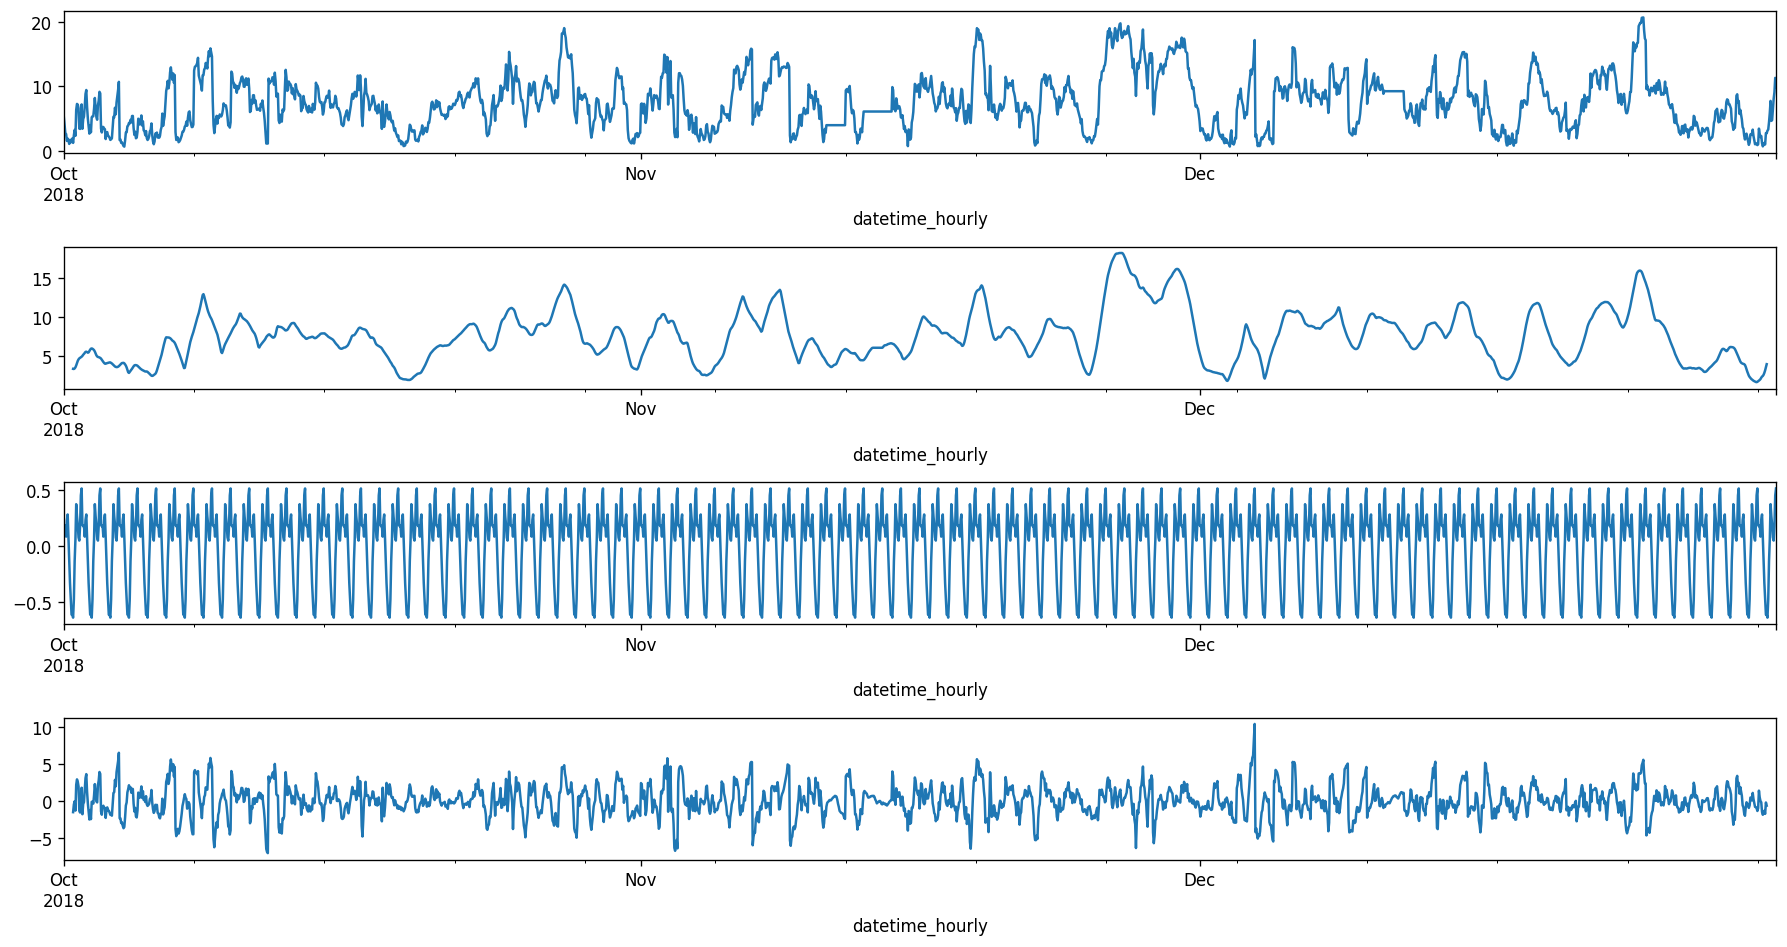

In [394]:
#Salvar a decoposição em result
from statsmodels.tsa.seasonal import seasonal_decompose
#result = seasonal_decompose(x=df_serie_temporal['windspeed'].asfreq('D').fillna(0).diff(7).dropna(), model='additive')
result = seasonal_decompose(x=df_serie_temporal['windspeed'].dropna(), model='additive')

#Plotar em tamanho maior
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
#result.plot()
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()

{'period1': 7.996376811594202, 'freq1': 0.12505663797009517, 'power1': 13.537976582231838, 'period2': 23.989130434782606, 'freq2': 0.04168554599003172, 'power2': 11.477083650191782, 'period3': 5.997282608695651, 'freq3': 0.16674218396012688, 'power3': 11.15133563921423, 'period4': 11.994565217391303, 'freq4': 0.08337109198006344, 'power4': 11.066063191795156, 'period5': 2.9986413043478257, 'freq5': 0.33348436792025377, 'power5': 3.846034394395181, 'period6': 3.4270186335403725, 'freq6': 0.29179882193022205, 'power6': 2.670294322938027, 'period7': 2.398913043478261, 'freq7': 0.4168554599003172, 'power7': 1.9767575957826287}


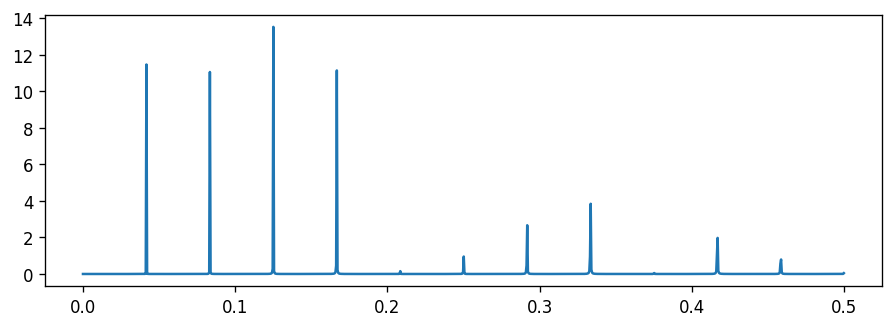

In [340]:
my_periodogram(result.seasonal)

# SARIMA

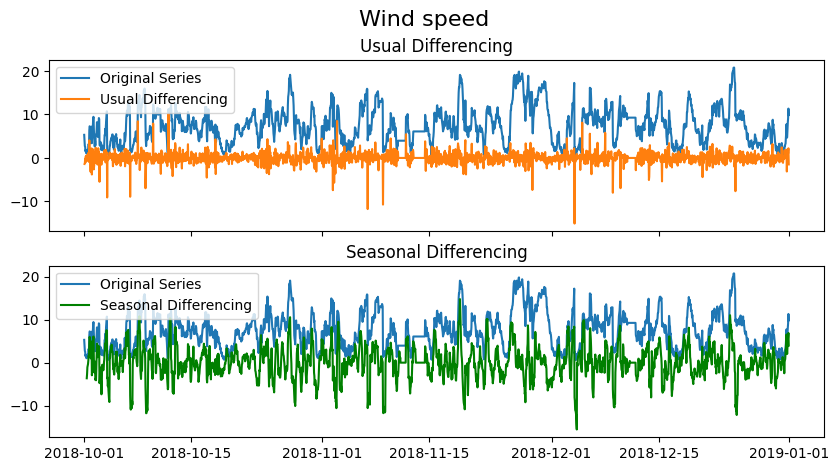

In [344]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df_serie_temporal[:], label='Original Series')
axes[0].plot(df_serie_temporal[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Defferencing
axes[1].plot(df_serie_temporal[:], label='Original Series')
axes[1].plot(df_serie_temporal[:].diff(8), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Wind speed', fontsize=16)
plt.show()

ADF Statistic: -6.346605
p-value: 0.000000


D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


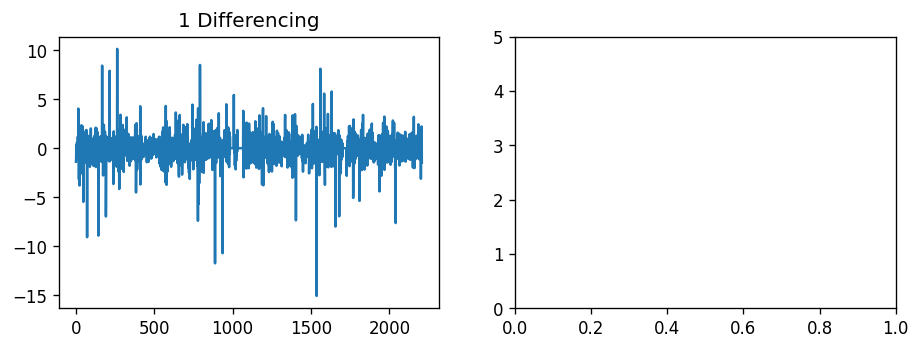

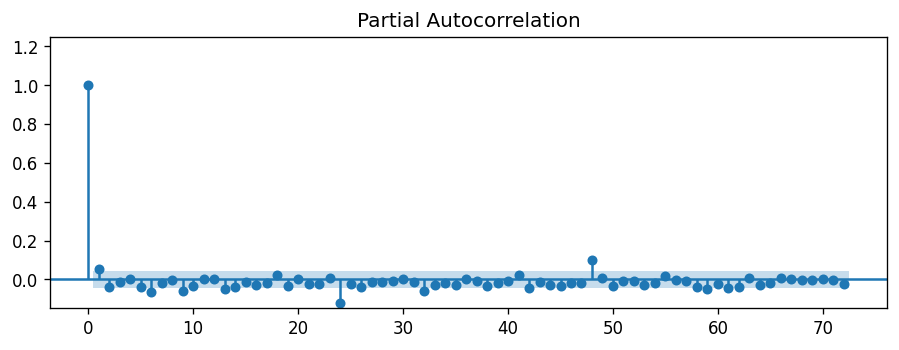

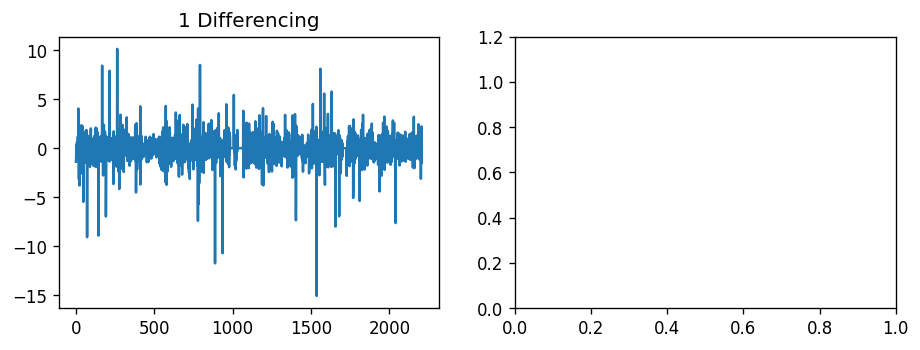

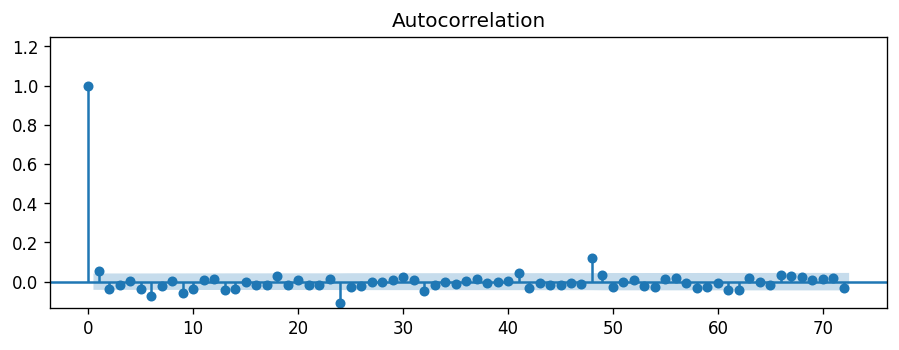

In [396]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from numpy import log
result = adfuller(df_serie_temporal.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# if p-value <= 0.05 Reject the null hypothesis (H0), 
# the data does not have a unit root and is stationary.
periods = 1
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_serie_temporal.diff(periods=periods).values)
axes[0].set_title(str(periods)+' Differencing')
axes[1].set(ylim=(0,5))
#plot_pacf(df_serie_temporal.diff(periods=periods).dropna().values, ax=axes[1], lags=20, auto_ylims=True)
plot_pacf(df_serie_temporal.diff(periods=periods).dropna().values, lags=72, auto_ylims=True, alpha=.05)
#plot_pacf(df_serie_temporal.dropna().values, ax=axes[1], lags=20, auto_ylims=True, alpha=.05)
# existe uma correlação significativa no lag 1 seguido por correlações que não são significativas. 
# Este padrão indica um termo auto-regressivo de ordem 1.
plt.show()

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_serie_temporal.diff(periods=periods).values)
axes[0].set_title(str(periods)+' Differencing')
axes[1].set(ylim=(0,1.2))
#plot_acf(df_serie_temporal.diff(periods=periods).dropna().values, ax=axes[1], lags=20, auto_ylims=True)
plot_acf(df_serie_temporal.diff(periods=periods).dropna().values, lags=72, auto_ylims=True, alpha=.05)

#plot_acf(df_serie_temporal['windspeed'].dropna().values, lags=80, auto_ylims=True, alpha=.05)
#
# Correlações significativas no primeiro ou segundo lag, 
#seguidas por correlações que não são significativas.

# Um termo de média móvel nos dados. O número de correlações significativas 
# indica a ordem do termo da média móvel.
plt.show()

,acf,ci_lim_inf,ci_lim_sup,significative
0,1.000000,1.000000,1.000000,True
1,0.052319,0.010599,0.094040,True
2,-0.037732,-0.079566,0.004102,False
3,-0.017494,-0.059388,0.024399,False
4,0.003128,-0.038779,0.045034,False
5,-0.037802,-0.079709,0.004105,False
6,-0.070578,-0.112544,-0.028612,True
7,-0.023228,-0.065400,0.018944,False
8,0.000968,-0.041226,0.043162,False
9,-0.057255,-0.099450,-0.015061,True


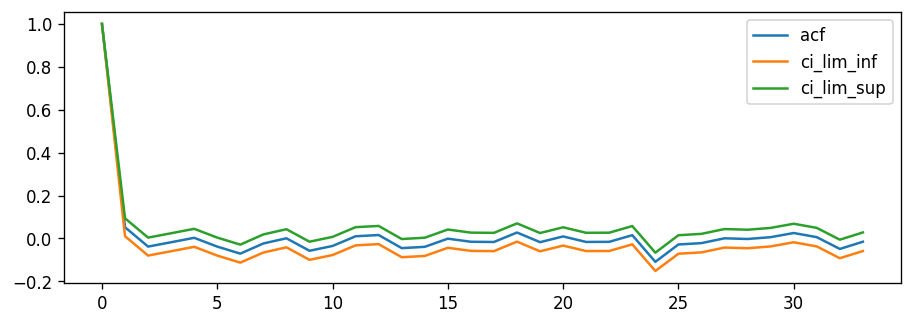

In [346]:
endog = df_serie_temporal['windspeed'].diff(periods=periods).dropna().values
acf, ci = sm.tsa.acf(endog, alpha=0.05)
pacf, ci2 = sm.tsa.pacf(endog, alpha=0.05)
df_acf = pd.concat([pd.DataFrame(data=acf, columns=['acf']), pd.DataFrame(data=ci, columns=['ci_lim_inf', 'ci_lim_sup'])],
                   axis=1)
df_acf['significative'] = ~df_acf['acf'].between(-1.96/np.sqrt(len(endog)), 1.96/np.sqrt(len(endog)))
df_acf.plot()
df_acf

,pacf,ci2_lim_inf,ci2_lim_sup,significative
0,1.000000,1.000000,1.000000,True
1,0.052343,0.010623,0.094063,True
2,-0.040617,-0.082337,0.001103,False
3,-0.013393,-0.055114,0.028327,False
4,0.003288,-0.038433,0.045008,False
5,-0.039619,-0.081339,0.002101,False
6,-0.066992,-0.108712,-0.025272,True
7,-0.019131,-0.060851,0.022589,False
8,-0.003526,-0.045246,0.038194,False
9,-0.061800,-0.103521,-0.020080,True


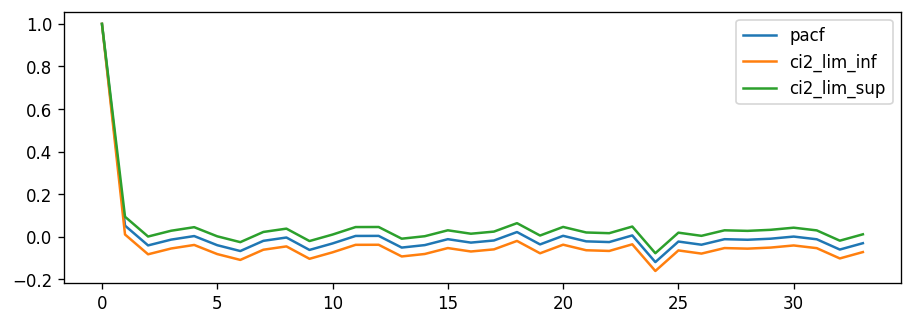

In [347]:
df_pacf = pd.concat([pd.DataFrame(data=pacf, columns=['pacf']), pd.DataFrame(data=ci2, columns=['ci2_lim_inf', 'ci2_lim_sup'])],
                   axis=1)
df_pacf['significative'] = ~df_pacf['pacf'].between(-1.96/np.sqrt(len(endog)), 1.96/np.sqrt(len(endog)))
df_pacf.plot()
df_pacf

In [350]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_serie_temporal, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

model2 = ARIMA(df_serie_temporal, order=(0,1,2))
model2_fit = model2.fit()
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              windspeed   No. Observations:                 2208
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3818.420
Date:                Fri, 07 Oct 2022   AIC                           7642.841
Time:                        11:28:59   BIC                           7659.939
Sample:                    10-01-2018   HQIC                          7649.088
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0545      0.019      2.928      0.003       0.018       0.091
ar.L2         -0.0407      0.022     -1.863      0.063      -0.083       0.002
sigma2         1.8634      0.018    100.780      0.0

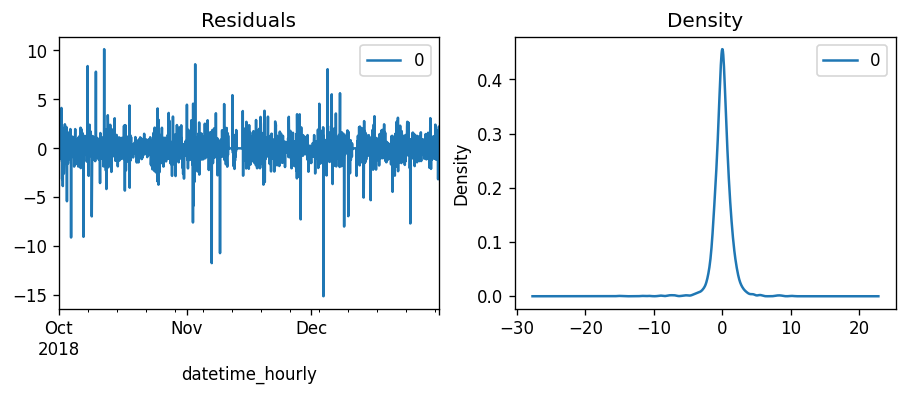

In [397]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

,lb_stat,lb_pvalue
1,0.011768,0.913615
2,0.012698,0.993671
3,0.523885,0.913613
4,0.524247,0.971098
5,3.271381,0.658226
6,13.402836,0.037067
7,14.645153,0.040827
8,14.653580,0.066242
9,21.761625,0.009666
10,23.900911,0.007868


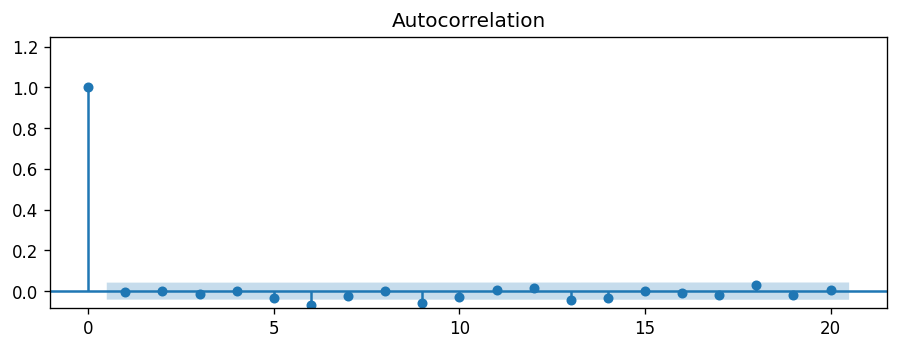

In [398]:
plot_acf(residuals, lags=20, auto_ylims=True, alpha=.05)

sm.stats.acorr_ljungbox(residuals.rename(columns={0:'res'})['res'], lags=None)
# se p_value > 0.05 não há correlação entre os pontos (portmanteau test) indicando white noise

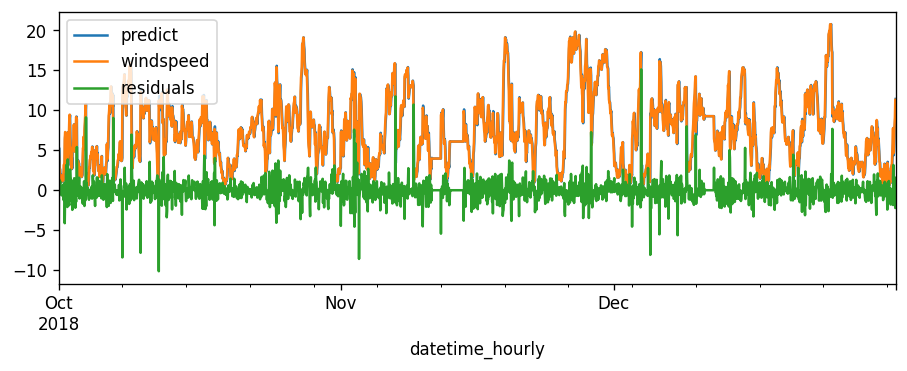

In [355]:
# Actual vs Fitted
fig, ax = plt.subplots()
model_fit.predict().plot(ax=ax, label='predict')
df_serie_temporal.plot(ax=ax, label='windspeed')

df_manual_predict = pd.concat([model_fit.predict(), df_serie_temporal], axis=1)
df_manual_predict['residuals'] = df_manual_predict['predicted_mean'] - df_manual_predict['windspeed']
df_manual_predict['residuals'].plot(ax=ax, label='residuals')
plt.legend()

In [356]:
df_serie_temporal.tail()

,windspeed
datetime_hourly,
2018-12-31 19:00:00,6.483333
2018-12-31 20:00:00,8.083333
2018-12-31 21:00:00,9.121667
2018-12-31 22:00:00,11.340000
2018-12-31 23:00:00,9.855000


<AxesSubplot:>

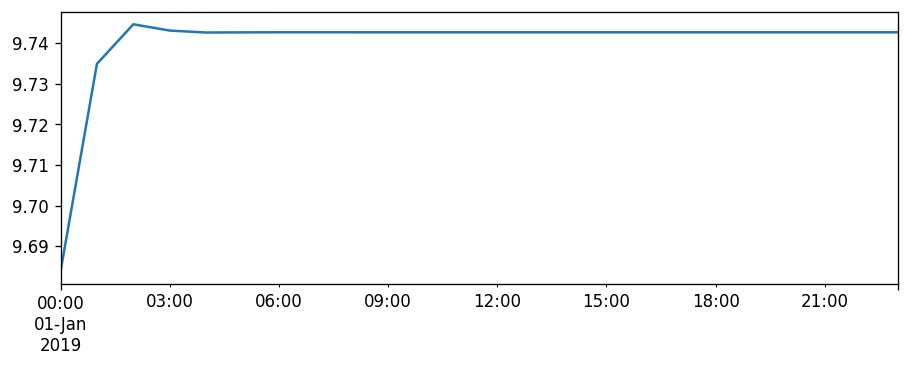

In [357]:
model_fit.forecast(steps=24).plot()

In [358]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_serie_temporal, start_p=1, start_q=1,
                         test='kpss',
                         max_p=3, max_q=3, m=1,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7646.471, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7650.537, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7646.484, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7645.982, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7648.542, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7645.161, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7646.105, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7643.166, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7643.986, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=7644.110, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7644.476, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2208
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -3818.583
Date:                Fri, 07 Oct 2022   AIC                           7643.166
Time:                        11:37:34   BIC                           7660.264
Sample:                             0   HQIC                          7649.413
                               - 2208                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0532      0.019      2.850      0.004       0.017       0.090
ma.L2         -0.0357      0.022     -1.636      0.102      -0.079       0.007
sigma2         1.8637      0.018    100.744      0.000       1.827       1.900
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             32556.45
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -1.16
Prob(H) (two-sided):                  0.64   Kurtosis:                        21.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [372]:
n_predict = 24
# Create Training and Test
train = df_serie_temporal[:-n_predict]
test = df_serie_temporal[-n_predict:]

In [373]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='kpss',
                         max_p=3, max_q=3, m=8,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[8] intercept   : AIC=inf, Time=5.38 sec
 ARIMA(0,0,0)(0,1,0)[8] intercept   : AIC=11951.641, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[8] intercept   : AIC=8346.738, Time=1.07 sec
 ARIMA(0,0,1)(0,1,1)[8] intercept   : AIC=9900.314, Time=2.88 sec
 ARIMA(0,0,0)(0,1,0)[8]             : AIC=11949.642, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[8] intercept   : AIC=8912.327, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[8] intercept   : AIC=8202.409, Time=2.21 sec
 ARIMA(1,0,0)(2,1,1)[8] intercept   : AIC=inf, Time=10.70 sec
 ARIMA(1,0,0)(1,1,1)[8] intercept   : AIC=inf, Time=4.74 sec
 ARIMA(0,0,0)(2,1,0)[8] intercept   : AIC=11817.419, Time=1.33 sec
 ARIMA(2,0,0)(2,1,0)[8] intercept   : AIC=8176.072, Time=3.13 sec
 ARIMA(2,0,0)(1,1,0)[8] intercept   : AIC=8313.468, Time=1.38 sec
 ARIMA(2,0,0)(2,1,1)[8] intercept   : AIC=inf, Time=12.76 sec
 ARIMA(2,0,0)(1,1,1)[8] intercept   : AIC=inf, Time=5.66 sec
 ARIMA(3,0,0)(2,1,0)[8] intercept   : AIC=8175.211, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2184
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 8)   Log Likelihood               -4061.796
Date:                            Fri, 07 Oct 2022   AIC                           8135.592
Time:                                    12:30:16   BIC                           8169.704
Sample:                                         0   HQIC                          8148.064
                                           - 2184                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8997      0.010    190.221      0.000       1.880       1.919
ar.L2         -0.9098      0.010    -94.693      0.000      -0.929      -0.891
ma.L1         -0.9679      0.009   -104.072      0.000      -0.986      -0.950
ar.S.L8       -0.6077      0.012    -49.110      0.000      -0.632      -0.583
ar.S.L16      -0.2455      0.010    -25.490      0.000      -0.264      -0.227
sigma2         2.4426      0.041     58.914      0.000       2.361       2.524
===================================================================================
Ljung-Box (L1) (Q):                   7.19   Jarque-Bera (JB):             14020.14
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.46
Prob(H) (two-sided):                  0.30   Kurtosis:                        15.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

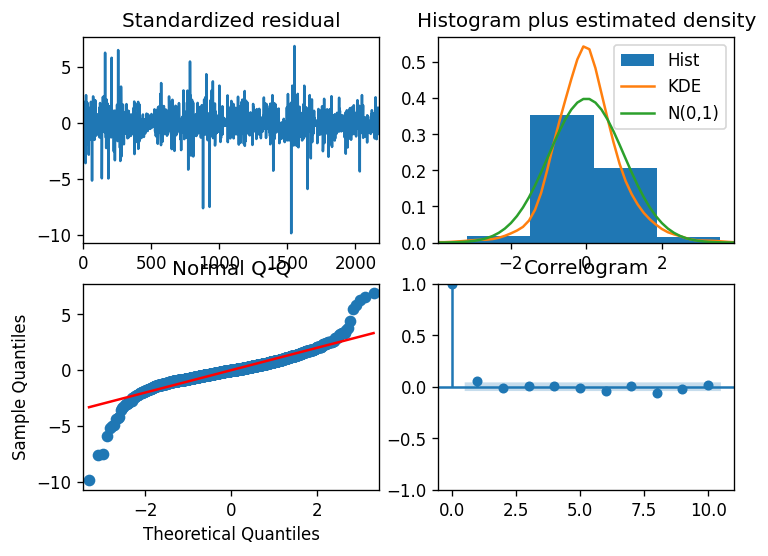

In [374]:
smodel.plot_diagnostics(figsize=(7,5))
plt.show()

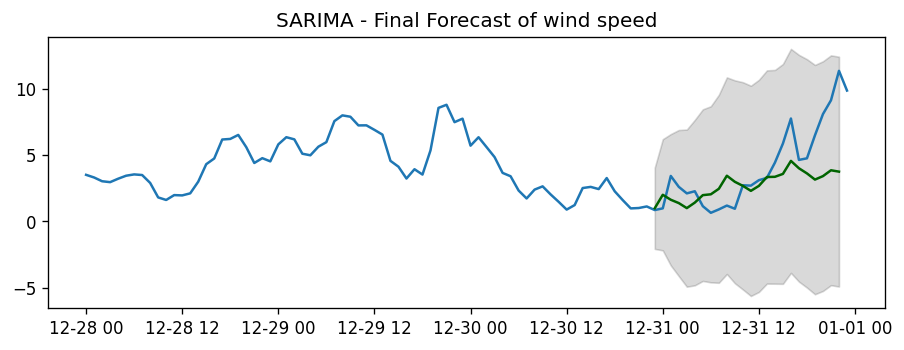

In [438]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='1H')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_serie_temporal[-96:], label='original data')
plt.plot(fitted_series, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of wind speed")
plt.show()

In [244]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    from statsmodels.tsa.stattools import acf
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual.T)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf((forecast-actual)[0])[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax, 'accuracy': 1-mape})

In [379]:
forecast_accuracy(fitted, test.values)

{'mape': 0.8374943486462003,
 'me': -1.447633469886003,
 'mae': 2.6163853874941734,
 'mpe': 0.24254151830590123,
 'rmse': 3.520506748183132,
 'acf1': 0.7846200615461812,
 'corr': 0.6670550218961031,
 'minmax': 0.3850104535931643,
 'accuracy': 0.16250565135379968}

In [386]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
data = df_serie_temporal['windspeed'].values
# fit model
model_sarimax = SARIMAX(data, order=(2, 1, 0), seasonal_order=(2, 1, 0, 24))
model_sarimax_fit = model_sarimax.fit(disp=False)
# make prediction
yhat = model_sarimax_fit.predict(len(data), len(data)+10)
print(yhat)

[ 9.12194117 10.14455563  9.56959817  8.76968846  8.18715284  8.02617111
  7.50473115  7.74884043  8.2670057   8.30432887  8.17536255]


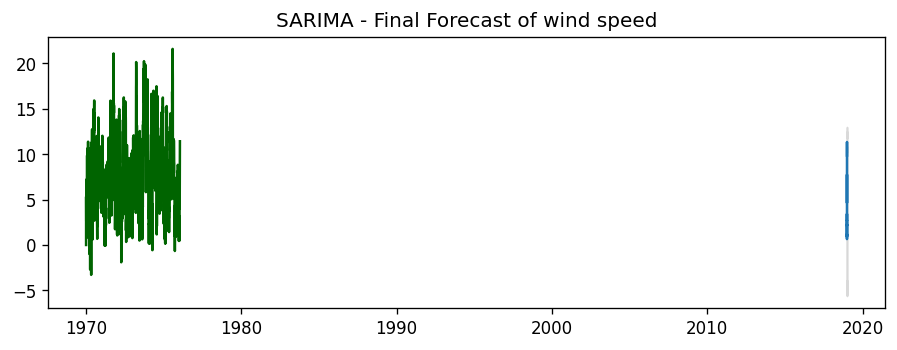

In [409]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='1H')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_serie_temporal[-96:], label='original data')
plt.plot(fitted_series, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of wind speed")
plt.show()

C:\Users\renat\AppData\Local\Temp\ipykernel_42040\3866516779.py:3: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  pred1 = ExponentialSmoothing(np.asarray(train['windspeed']), trend='additive', damped=False, seasonal='additive',



== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  1.0
Smoothing Slope:  0.0
Smoothing Seasonal:  0.0
Initial Level:  4.8322
Initial Slope:  -0.0021
Initial Seasons:  [0.4805 0.3832 0.3079 0.2433 0.2718 0.393  0.5325 0.5544]

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2184
Model:             ExponentialSmoothing   SSE                           4071.835
Optimized:                         True   AIC                           1384.492
Trend:                         Additive   BIC                           1452.759
Seasonal:                      Additive   AICC                          1384.685
Seasonal Periods:                     8   Date:                 Mon, 10 Oct 2022
Box-Cox:                          False   Time:                         09:14:00
Box-Cox Coeff.:                    None                                         
                          

<AxesSubplot:xlabel='datetime_hourly'>

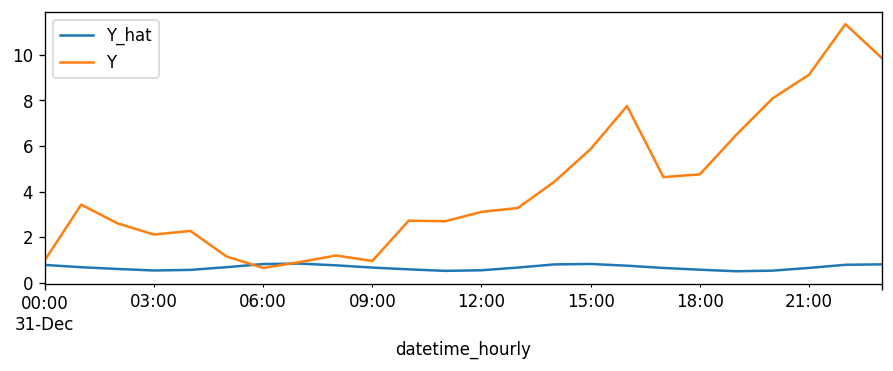

In [435]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

pred1 = ExponentialSmoothing(np.asarray(train['windspeed']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 8).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred1.params['smoothing_trend'], 4))
print('Smoothing Seasonal: ', np.round(pred1.params['smoothing_seasonal'], 4))
print('Initial Level: ', np.round(pred1.params['initial_level'], 4))
print('Initial Slope: ', np.round(pred1.params['initial_trend'], 4))
print('Initial Seasons: ', np.round(pred1.params['initial_seasons'], 4))
print('')
print(pred1.summary())

### Forecast for next 16 months

y_pred1 =  pred1.forecast(steps = 24)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['windspeed']})
print(df_pred1)
df_pred1.plot()

In [345]:
power_pred = regr.predict(np.array([[5.82743478], [5.83516794], [5.39783627], [4.83927404], [3.78919612],
       [3.93621931], [4.23023257], [4.06744627], [3.60148641], [3.92854654],
       [3.65689476], [3.85803359], [3.7400386] , [3.55276618], [4.15464719],
       [3.99091356], [4.4248119] , [5.48624902], [5.48233249], [5.60240412],
       [5.93836784], [6.34661286], [6.57028208], [6.52455381]]))
power_pred

array([483.35061444, 485.47016187, 376.07989526, 264.55029557,
        88.52617001, 110.2344316 , 158.11466801, 131.03715807,
        63.97185741, 109.05563392,  70.81331922,  98.44922013,
        81.7267258 ,  58.25141982, 145.4067603 , 118.76498433,
       191.49114919, 396.42256724, 395.50250478, 424.52043122,
       514.3234936 , 637.02208351, 709.10350414, 694.0715179 ])

array([100.6 , 100.27,  99.66,  98.59,  98.96, 100.2 , 100.18, 101.08,
       105.15, 106.25, 107.2 , 109.37, 107.32, 109.55, 111.77, 111.79,
       110.83, 107.42, 105.62, 105.59, 105.62, 105.53, 104.74, 102.01])

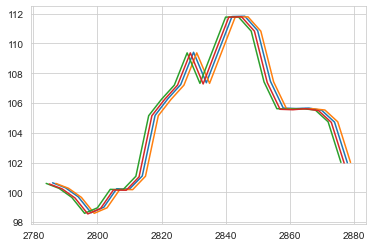

In [346]:
df_pld = pd.read_parquet("C:\\Users\\renat\\Downloads\\2018-11.parquet")
df_pld.query('Submercado == "NORDESTE"').tail(24).pld.plot()
df_pld.query('Submercado == "NORTE"').tail(24).pld.plot()
df_pld.query('Submercado == "SUDESTE"').tail(24).pld.plot()
df_pld.query('Submercado == "SUL"').tail(24).pld.plot()
pld_next_day = df_pld.query('Submercado == "SUDESTE"').tail(24).pld.values
pld_next_day

[483.35061444 485.47016187 376.07989526 264.55029557  88.52617001
 110.2344316  158.11466801 131.03715807  63.97185741 109.05563392
  70.81331922  98.44922013  81.7267258   58.25141982 145.4067603
 118.76498433 191.49114919 396.42256724 395.50250478 424.52043122
 514.3234936  637.02208351 709.10350414 694.0715179 ]
[48.62507181 48.67809313 37.48012236 26.08201364  8.76054978 11.04549005
 15.83992744 13.24523594  6.72664081 11.5871611   7.59118782 10.76739121
  8.77091221  6.38144304 16.2521136  13.2767376  21.22296407 42.58371217
 41.77297455 44.82511233 54.32284739 67.22494047 74.27150102 70.80223554]
[483.35061444 485.47016187 376.07989526 264.55029557  88.52617001
 110.2344316  158.11466801 131.03715807  63.97185741 109.05563392
  70.81331922  98.44922013  81.7267258   58.25141982 145.4067603
 118.76498433 191.49114919 396.42256724 395.50250478 424.52043122
 514.3234936  637.02208351 709.10350414 694.0715179 ]
[48.62507181 48.67809313 37.48012236 26.08201364  8.76054978 11.04549005


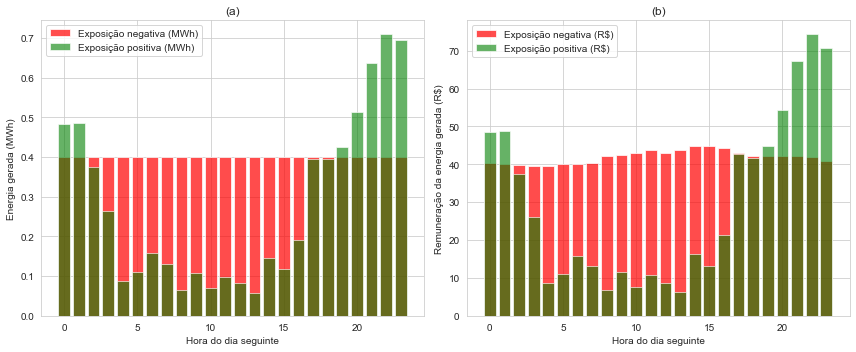

Exposição diária (MWh):-2.7937394326622336
Exposição diária (R$):-297.983620901334


In [398]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.bar(x=list(range(0,24)), height=[400/1000] * 24, label = 'Exposição negativa (MWh)', alpha=0.7, color='red')
#plt.plot((power_pred/1000) * pld_next_day, label = 'Remuneração da energia')
ax1.bar(x=list(range(0,24)), height=(power_pred/1000), label = 'Exposição positiva (MWh)', alpha=0.6, color='green')
ax1.set_xlabel('Hora do dia seguinte')
ax1.set_ylabel('Energia gerada (MWh)')
ax1.set_title('(a)')
ax1.legend()
print(power_pred)
print((power_pred/1000) * pld_next_day)

ax2.bar(x=list(range(0,24)), height=(400/1000) * pld_next_day, label = 'Exposição negativa (R$)', alpha=0.7, color='red')
#plt.plot((power_pred/1000) * pld_next_day, label = 'Remuneração da energia')
ax2.bar(x=list(range(0,24)), height=(power_pred/1000) * pld_next_day, label = 'Exposição positiva (R$)', alpha=0.6, color='green')
ax2.set_xlabel('Hora do dia seguinte')
ax2.set_ylabel('Remuneração da energia gerada (R$)')
ax2.set_title('(b)')
ax2.legend()
print(power_pred)
print((power_pred/1000) * pld_next_day)
plt.tight_layout()
plt.show()

print(f'Exposição diária (MWh):{-np.sum([400/1000] * 24) + np.sum(power_pred/1000)}')
print(f'Exposição diária (R$):{-np.sum((400/1000) * pld_next_day) + np.sum((power_pred/1000) * pld_next_day)}')

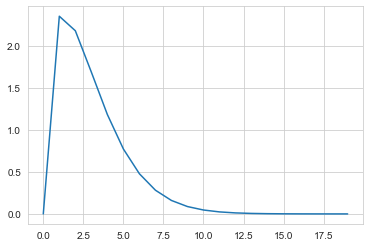

weibull parameters: k=1.37, c=0.31


D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


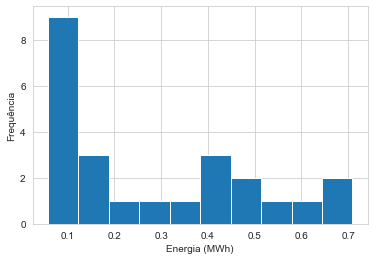

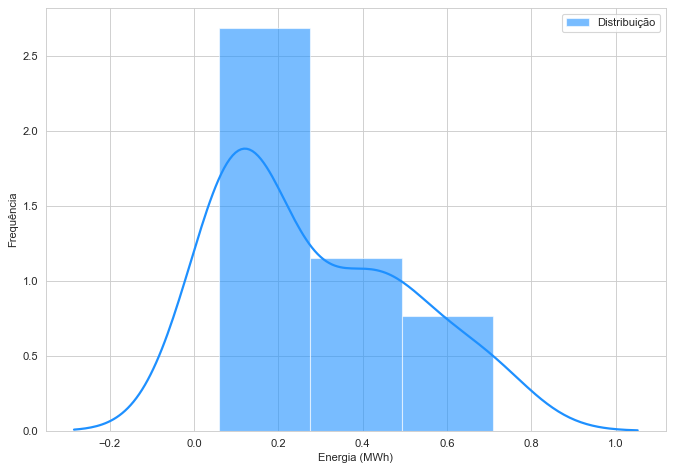

In [461]:
# weibull distribution
arrWind = (power_pred/1000)
try:
    k_weibull = np.power(arrWind.std() / arrWind.mean(), -1.086)
except ZeroDivisionError:
    k_weibull = 2  # distribuição de rayleigh (default)
try:
    c_weibull = arrWind.mean() / math.gamma(1 + (1 / k_weibull))
except ZeroDivisionError:
    c_weibull = 1
dx = 0.1
bins = np.arange(0, 2, dx)

def f_weibull(v, k, c):
    return (k / c) * np.power((v / c), k - 1) * np.exp(-np.power(v / c, k))

plt.plot(f_weibull(bins, k_weibull, c_weibull))
plt.show()
print(f'weibull parameters: k={round(k_weibull, 2)}, c={round(c_weibull, 2)}')

plt.hist((power_pred/1000))
plt.ylabel("Frequência")
plt.xlabel('Energia (MWh)')

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot((power_pred/1000), color="dodgerblue", label="Distribuição", **kwargs)
plt.ylabel("Frequência")
plt.xlabel('Energia (MWh)')
#plt.xlim(0,1)
plt.legend();